In [99]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import anndata as ad
import numpy as np
import scipy.sparse as sp
from scanpy.external.pp import mnn_correct
from combat.pycombat import pycombat
import scanorama
from glob import glob
from collections import Counter
import seaborn as sns

In [7]:
def calc_umap(adata, use_rep="X_pca"):
    if use_rep == "X_pca":
        sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)  # Select top 2000 HVGs
        sc.pp.pca(adata, n_comps=50, mask_var="highly_variable")
        sc.pp.neighbors(adata, n_pcs=50)
        sc.tl.umap(adata)

        print('Created PCA components in .obsm.X_pca')
    
    # Run neighbors and UMAP
    sc.pp.neighbors(adata, use_rep=use_rep, n_neighbors=15)  # Use PCA representation
    sc.tl.umap(adata)
    return adata

def plot_umap(adata):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    # Remove frame around each subplot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
    sc.pl.umap(adata, color='sample', title='UMAP of all samples', show=False, ax=ax)
    # Modify legend labels to replace "_" with space
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_text(text.get_text().replace("sample", "Sample").replace("_", " "))
    plt.savefig('nano_umap.png', dpi=150, bbox_inches='tight')
    plt.show()

# Read and merge data

In [103]:
files = sorted(glob('../data/samples/*.h5ad'))
# Load AnnData objects
adata_list = [sc.read_h5ad(file) for file in files]

In [4]:
sample_names = ['Sample 1 - 40 nm NPs', 'Sample 2 - 200 nm NPs', 'Sample 3 - 40 + 200 nm NPs', 'Sample 4 - control']
samples = []
for i, adata in enumerate(adata_list):
    sample = f'sample_{i+1}'
    adata.obs['sample'] = sample # Add a column 'sample' to keep track of the sample source
    adata.obs.index = [f"{f'sample_{i+1}'}_{x}" for x in adata.obs.index]  # Modify the index to be unique
    # adata_list[i].var.set_index('var.festures', inplace=True) # When changinf on .var have to use adata_list[i] instead adata
    # adata_list[i].var = adata.var[[]]
    samples.append(sample)

In [5]:
# Merge all AnnData objects
merged_adata =  ad.concat(adata_list, axis=0, join='inner')  # adata_list[0].concatenate(adata_list[1:], join='inner', index_unique=None)
merged_adata.write_h5ad('../data/merged.h5ad', compression='gzip')

In [6]:
merged_adata.var

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[22000 rows x 0 columns]

In [68]:
# common_genes = set.intersection(*(set(adata.var_names) for adata in adata_list))
# # Subset each AnnData object to keep only common genes
# adata_list = [adata[:, adata.var_names.isin(common_genes)] for adata in adata_list]
# # To ensure genes are correctly aligned during the merge, sort var_names in the same order for all AnnData objects
# for adata in adata_list:
#     adata = adata[:, sorted(adata.var_names)]
#     adata.var = adata.var[[]]

In [48]:
# import scipy.sparse as sp

# # Extract the sparse matrices and concatenate them
# sparse_matrices = [adata.X.todense() for adata in adata_list]
# concatenated_matrix = np.vstack(sparse_matrices)
# merged_adata.X = sp.csr_matrix(concatenated_matrix)

In [49]:
# common_genes = set(adata_list_old[0].var.index).intersection(set(adata_list_old[1].var.index)).intersection(set(adata_list_old[2].var.index)).intersection(set(adata_list_old[3].var.index))
# for i, adata in enumerate(adata_list_old):
#     sample = f'sample_{i+1}'
#     adata.obs['sample'] = sample # Add a column 'sample' to keep track of the sample source
#     adata.obs.index = [f"{f'sample_{i+1}'}_{x}" for x in adata.obs.index]  # Modify the index to be unique
#     adata_list_old[i] = adata[:, adata.var.index.isin(common_genes)].copy()

In [108]:
# old = merged_adata_old.X
# new = merged_adata.X

In [ ]:
# for i in range(new.shape[0]):
#     for j in range(new.shape[1]):
#         if abs(new[i, j] - old[i, j]) > 0.00001:
#             print(i, j, old[i, j], new[i, j]  )
#     if i % 1000 == 0:
#         print(i, '--------')

In [ ]:
# for hh in range(4):
#     new = adata_list[hh].X.toarray()
#     old = adata_list_old[hh].X.toarray()
#     for i in range(new.shape[0]):
#         for j in range(new.shape[1]):
#             if abs(new[i, j] - old[i, j]) > 0.00001:
#                 print(hh, i, j, old[i, j], new[i, j]  )
        # if i % 1000 == 0:
        #     print(i, '--------')

/tmp/ipykernel_6963/829013962.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=qc_df, x='Sample', y='n_genes_per_cell', inner='box', palette='grey', cut=0)


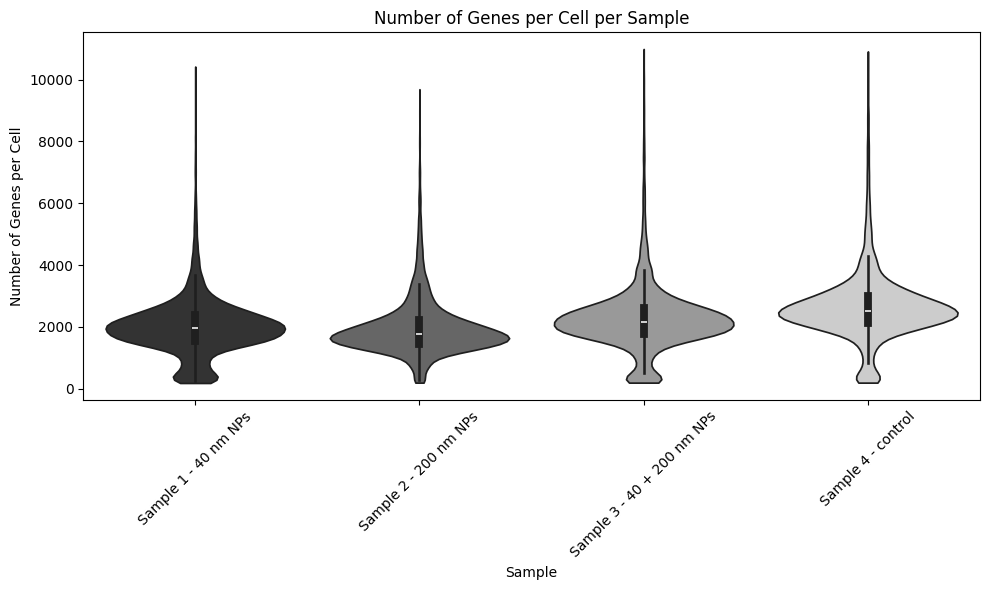

In [110]:


# Combine data into a single DataFrame for visualization
qc_data = []

for adata, sample_name in zip(adata_list, sample_names):
    # Calculate the number of genes per cell
    adata.obs['n_genes_per_cell'] = (adata.X > 0).sum(axis=1)  # For sparse matrix compatibility
    qc_data.append(pd.DataFrame({'Sample': sample_name, 'n_genes_per_cell': adata.obs['n_genes_per_cell']}))

# Combine QC data from all samples
qc_df = pd.concat(qc_data, ignore_index=True)

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=qc_df, x='Sample', y='n_genes_per_cell', inner='box', palette='grey', cut=0)

# Customize the plot
plt.title('Number of Genes per Cell per Sample')
plt.ylabel('Number of Genes per Cell')
plt.xlabel('Sample')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('nano_qc.png', dpi=150, bbox_inches='tight')
# Show the plot
plt.show()


In [108]:
import scanpy as sc

# Calculate QC metrics for each AnnData object
for adata in adata_list:
    sc.pp.calculate_qc_metrics(adata, inplace=True)

# Access the results
for sample_name, adata in zip(samples, adata_list):
    print(f"{sample_name} - Number of genes per cell statistics:")
    print(f"Min: {adata.obs['n_genes_by_counts'].min()}")
    print(f"Max: {adata.obs['n_genes_by_counts'].max()}")
    print(f"Mean: {adata.obs['n_genes_by_counts'].mean()}")


sample_1 - Number of genes per cell statistics:
Min: 189
Max: 10419
Mean: 2012.5887028401864
sample_2 - Number of genes per cell statistics:
Min: 200
Max: 9687
Mean: 1985.0030729046632
sample_3 - Number of genes per cell statistics:
Min: 200
Max: 10987
Mean: 2260.571977681339
sample_4 - Number of genes per cell statistics:
Min: 200
Max: 10911
Mean: 2642.1810939989377


# Cell annotation overview

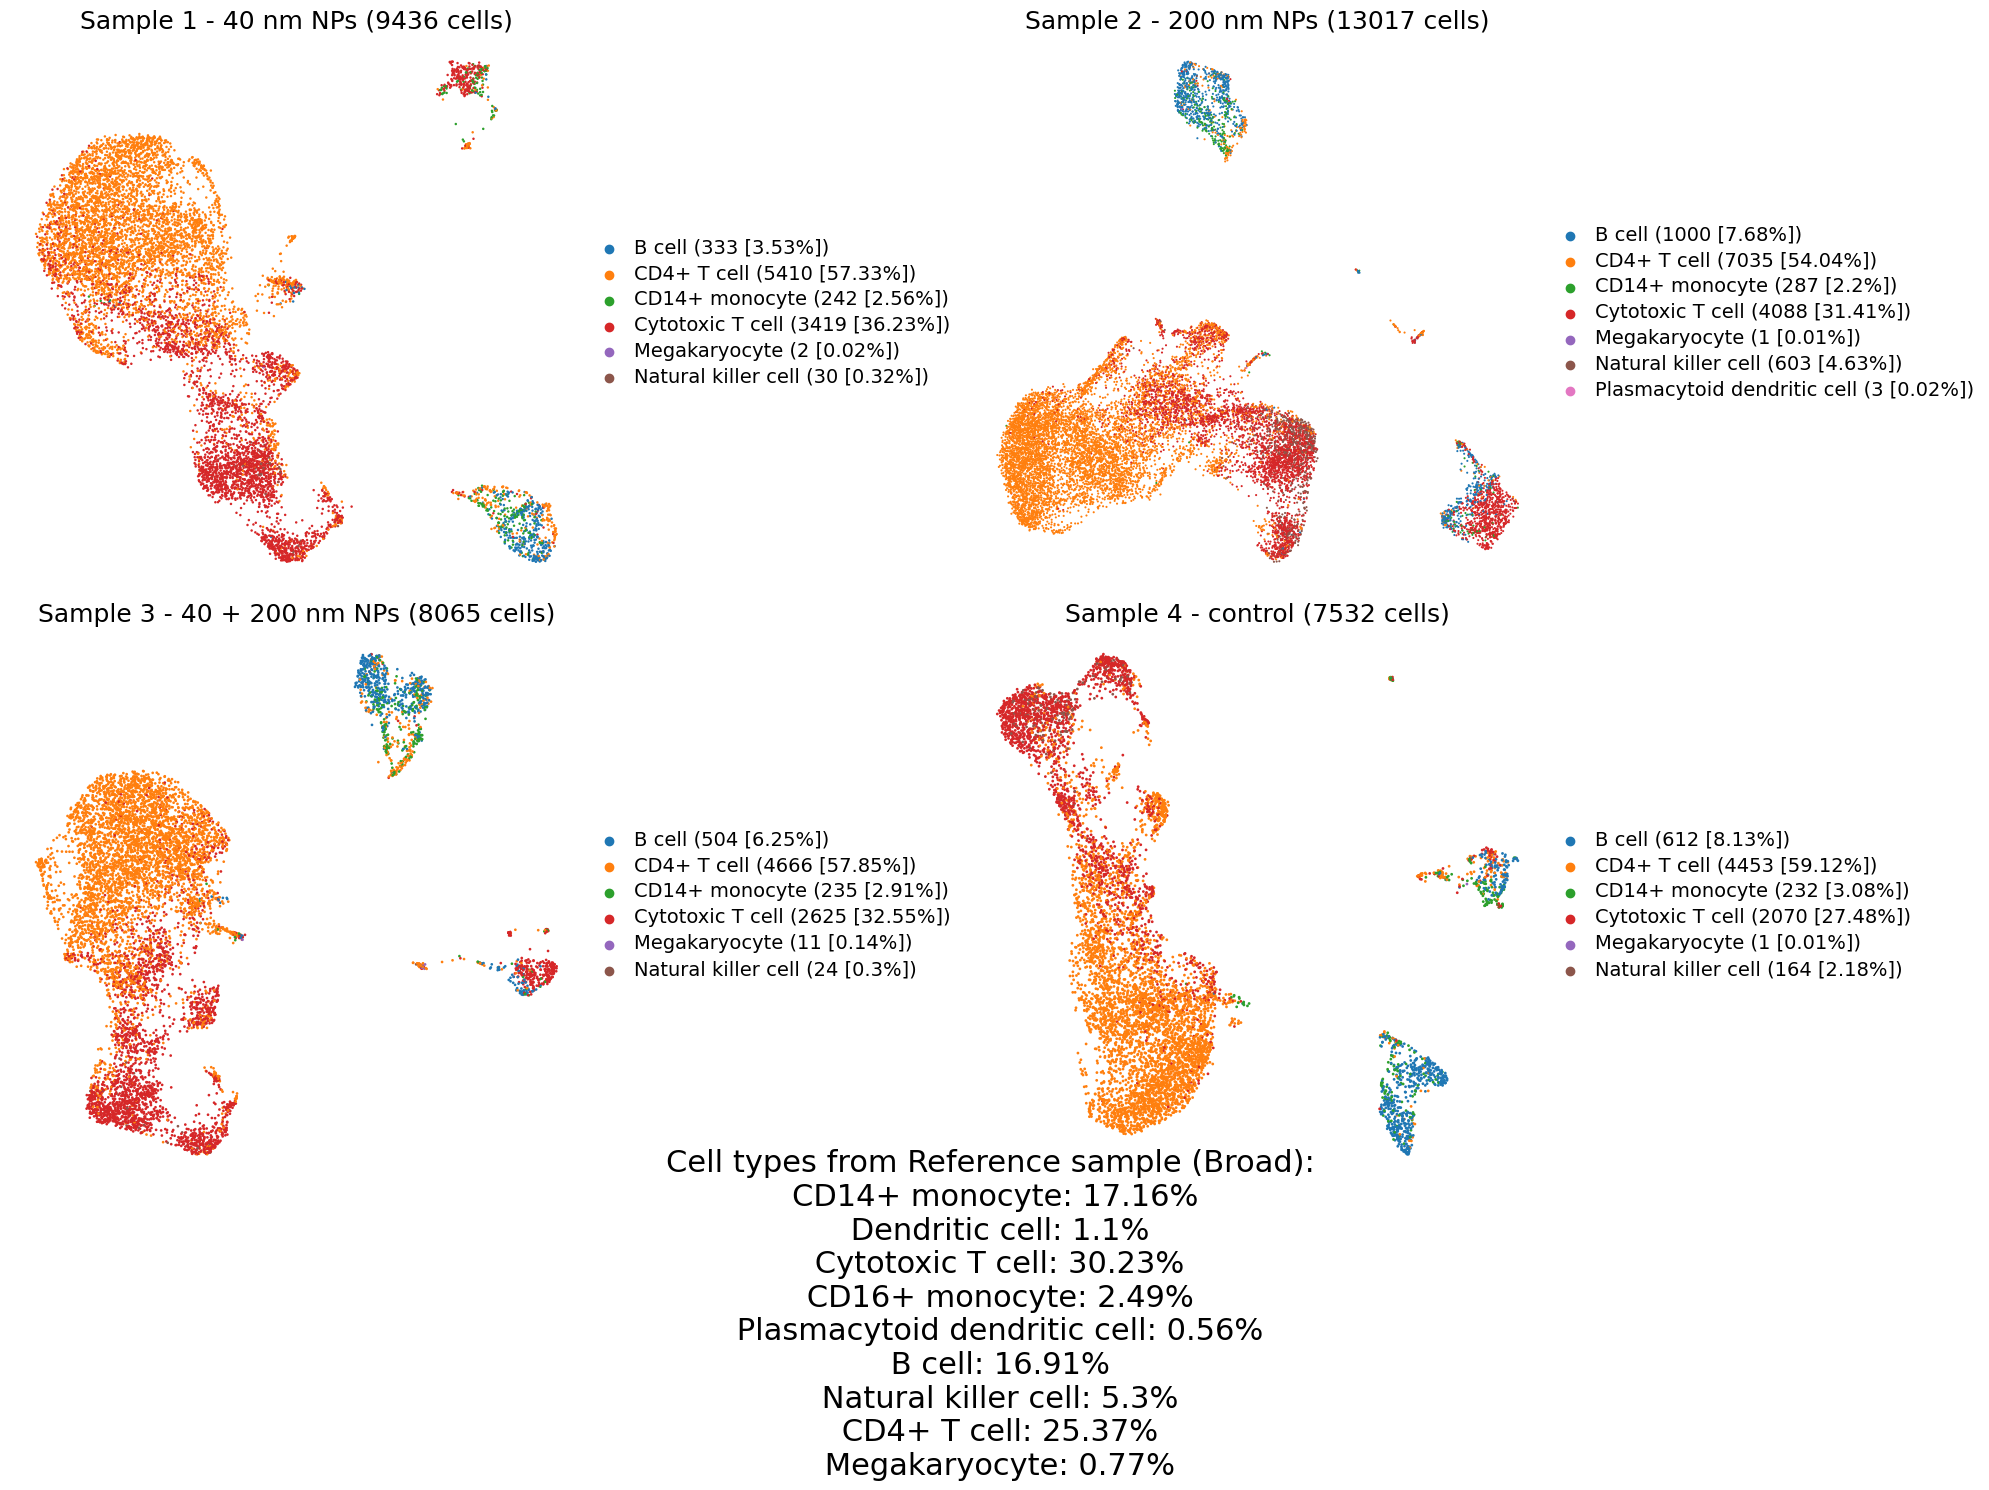

In [9]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()
cell_type_col = "predicted.celltype"  # Annotation column name
adata_ref = sc.read_h5ad('../data/ref_broad_pbmc/sc.h5ad')

for i, (adata, ax) in enumerate(zip(adata_list, axes)):
    # Calculate cell type counts and percentages

    cell_counts = adata.obs[cell_type_col].value_counts()
    total_cells = cell_counts.sum()
    percentages = (cell_counts / total_cells * 100).round(2)
    
    # Modify categories to include counts and percentages
    updated_categories = [
        f"{cell_type} ({count} [{percentage}%])"
        for cell_type, count, percentage in zip(cell_counts.index, cell_counts, percentages)
    ]
    mapping = dict(zip(cell_counts.index, updated_categories)) 
    adata.obs[cell_type_col + "_updated"] = adata.obs[cell_type_col].map(mapping)#.fillna("Unknown")
    
    # Plot UMAP
    sc.pl.umap(
        adata,
        color=cell_type_col + "_updated",
        ax=ax,
        show=False,
        title=sample_names[i],
        legend_loc="right margin"
    )
    ax.set_title(f'{sample_names[i]} ({len(adata)} cells)', size=18)
    # Remove frame around each subplot
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    # Increase the legend font size
    legend = ax.get_legend()
    if legend:
        for text in legend.get_texts():
            text.set_fontsize(14)  # Adjust the font size
    ax.set_xlabel(None)
    ax.set_ylabel(None)


# Add a horizontal legend at the bottom of the figure with reference cell types
# Define legend items and title
data = Counter(adata_ref.obs['CellType'])
total = sum(data.values())
# percentages = {key: np.round(value / total, 2) * 100 for key, value in data.items()}
legend_items = [f'{key}: {np.round(value / total * 100, 2)}' for key, value in data.items() if not str(key) in ['Unassigned', 'nan']]

fig.text(
    0.5, -0.1,  # Position: centered horizontally, slightly below the figure
    "Cell types from Reference sample (Broad): \n" + "%\n ".join(legend_items) + '%',  # Legend text
    ha='center', va='center', fontsize=22  # Alignment and font size
)

# Adjust layout and display
plt.tight_layout()
plt.savefig('nano.png', dpi=150, bbox_inches='tight')
plt.show()


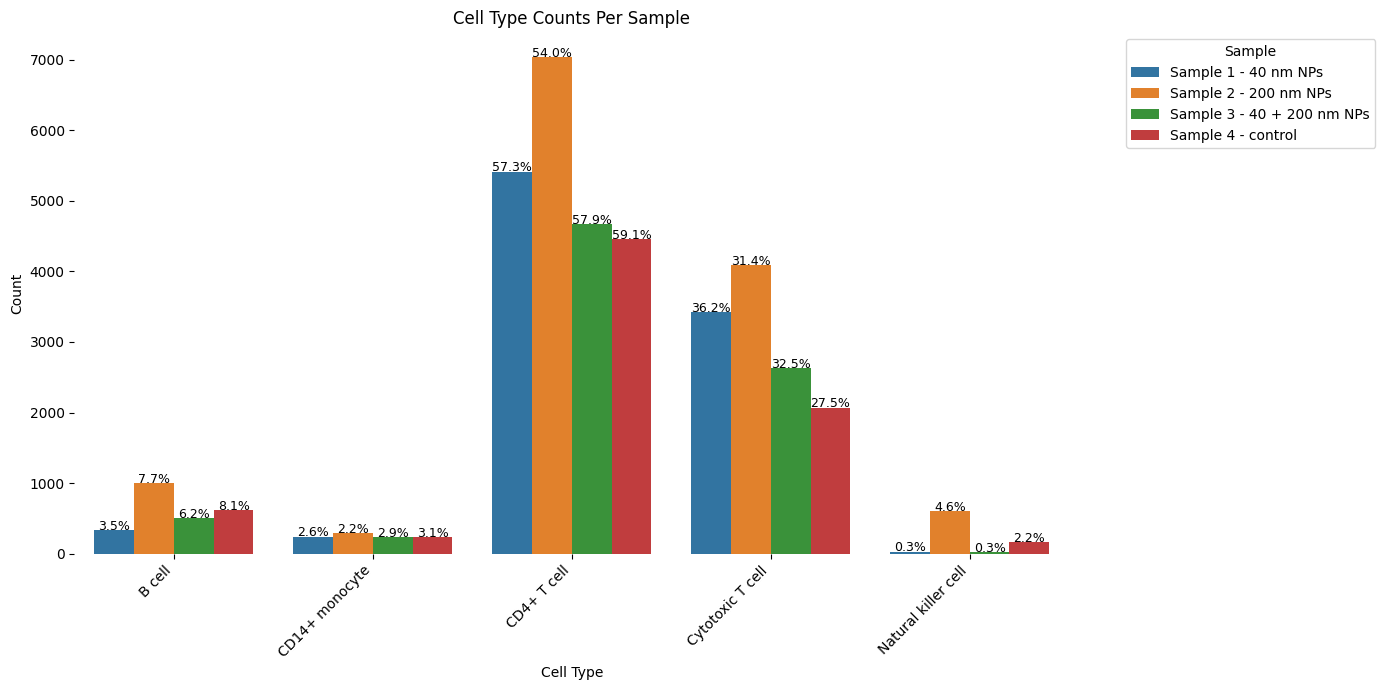

In [114]:
# Define the specific cell types to include in the plot
cell_types_to_plot = ['B cell', 'CD14+ monocyte', 'CD4+ T cell', 'Cytotoxic T cell', 'Natural killer cell']

# Combine the data from adata_list into a single DataFrame
data = []
for i, adata in enumerate(adata_list):
    sample_name = f"Sample {i+1}"
    total_cells = len(adata)  # Total cells in the sample
    celltype_counts = adata.obs['predicted.celltype'].value_counts()
    for celltype in cell_types_to_plot:
        count = celltype_counts.get(celltype, 0)  # Get count or 0 if cell type is absent
        percentage = (count / total_cells) * 100
        data.append({'Sample': sample_names[i], 'Cell Type': celltype, 'Count': count, 'Percentage': percentage})

# Create a DataFrame for plotting
df = pd.DataFrame(data)

# Set up the plot
plt.figure(figsize=(14, 7))
sns.barplot(data=df, x='Cell Type', y='Count', hue='Sample', palette='tab10')

# Annotate the plot with percentages
for bar, percentage in zip(plt.gca().patches, df['Percentage']):
    height = bar.get_height()
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,  # Position above the bar
        f"{percentage:.1f}%",
        ha="center",
        fontsize=9,
        color="black"
    )

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.title('Cell Type Counts Per Sample')
plt.ylabel('Count')
plt.xlabel('Cell Type')
plt.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.box(None)

# Show the plot
plt.savefig('nano_ct_per_sample.png', dpi=150, bbox_inches='tight')
plt.show()


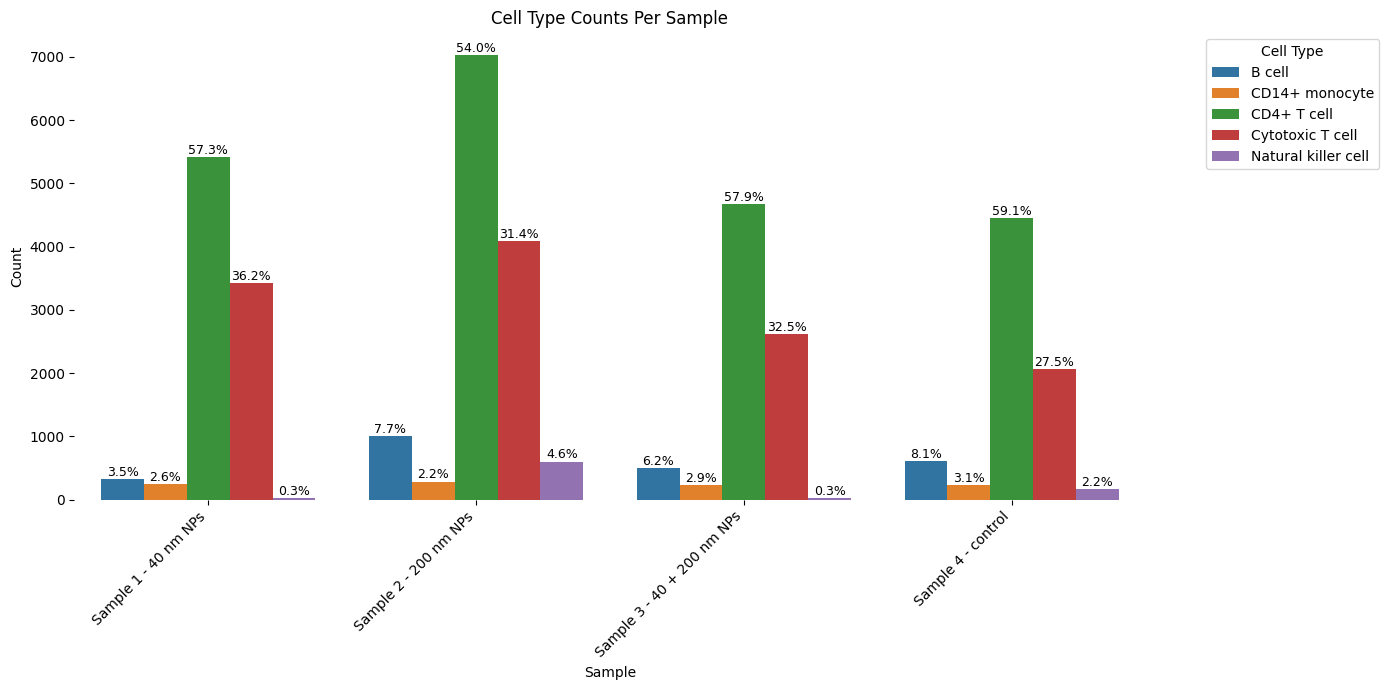

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the specific cell types to include in the plot
cell_types_to_plot = ['B cell', 'CD14+ monocyte', 'CD4+ T cell', 'Cytotoxic T cell', 'Natural killer cell']

# Combine the data from adata_list into a single DataFrame
data = []
for i, adata in enumerate(adata_list):
    sample_name = f"Sample {i+1}"
    total_cells = len(adata)  # Total cells in the sample
    celltype_counts = adata.obs['predicted.celltype'].value_counts()
    for celltype in cell_types_to_plot:
        count = celltype_counts.get(celltype, 0)  # Get count or 0 if cell type is absent
        percentage = (count / total_cells) * 100
        data.append({'Sample': sample_names[i], 'Cell Type': celltype, 'Count': count, 'Percentage': percentage})

# Create a DataFrame for plotting
df = pd.DataFrame(data)

# Set up the plot with samples on the x-axis and cell types grouped
plt.figure(figsize=(14, 7))
ax = sns.barplot(data=df, x='Sample', y='Count', hue='Cell Type', palette='tab10')

# Annotate the plot with percentages
for container, cell_type in zip(ax.containers, cell_types_to_plot):
    for bar, percentage in zip(container, df[df['Cell Type'] == cell_type]['Percentage']):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 1,  # Position above the bar
            f"{percentage:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9,
            color="black"
        )

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.title('Cell Type Counts Per Sample')
plt.ylabel('Count')
plt.xlabel('Sample')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.box(False)
plt.savefig('nano_sample_per_ct.png', dpi=150, bbox_inches='tight')

# Show the plot
plt.show()


# Umap

Created PCA components in .obsm.X_pca


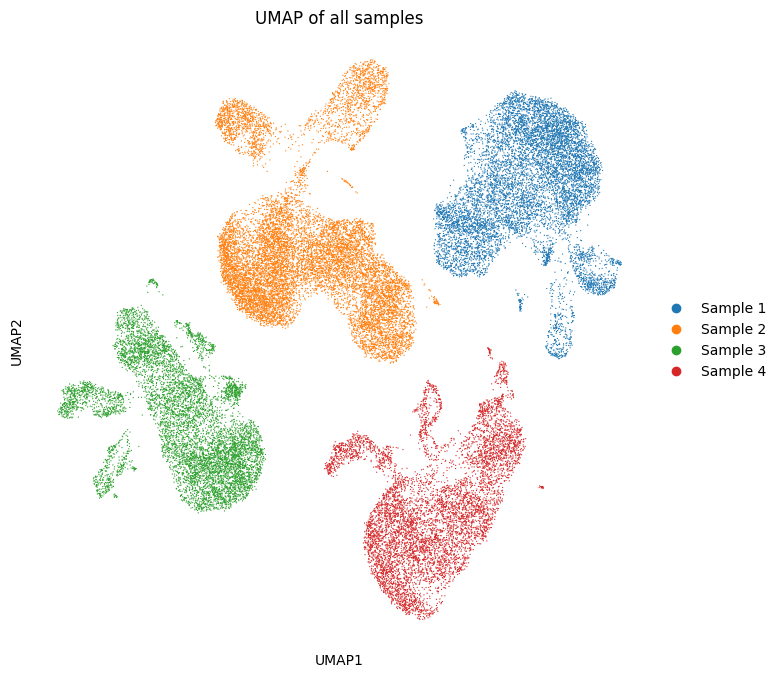

In [100]:
adata_umap = calc_umap(merged_adata.copy())
plot_umap(adata_umap)

# Batch effects correction - pycombat

In [4]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')

samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

# before = adata_combined.X.copy()
# sc.pp.combat(adata_combined, key='sample', inplace=True)

df_expression = pd.DataFrame(adata_combined.X.toarray(), index=adata_combined.obs.index, columns=adata_combined.var.index).T
# run pyComBat
df_corrected = pycombat(df_expression, adata_combined.obs['sample'].values)


# after = df_corrected
# print((before != after).sum())  # Count changes


Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created PCA components in .obsm.X_pca


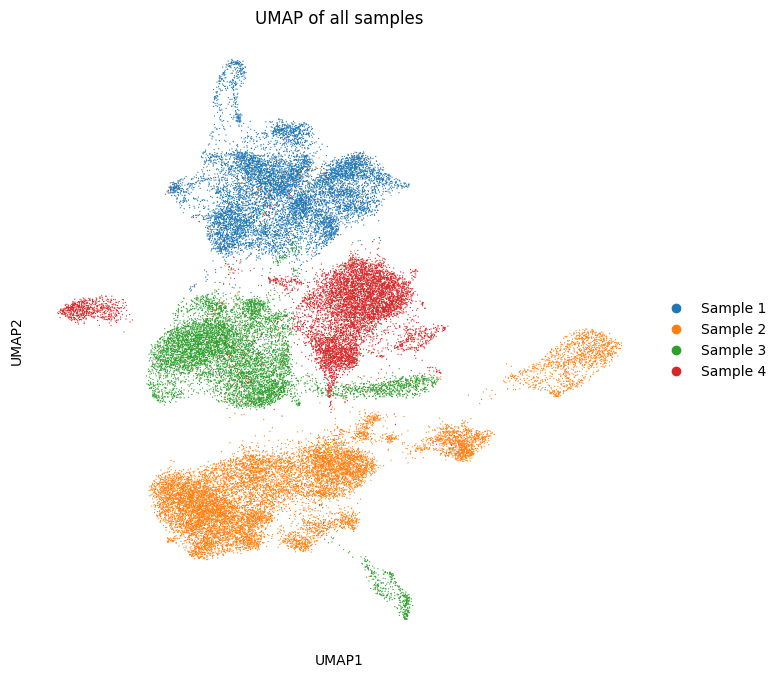

In [7]:
adata_corrected = adata_combined.copy()
adata_corrected.X = df_corrected.T.values
adata_corr_umap = calc_umap(adata_corrected)
plot_umap(adata_corr_umap)

# Batch effects correction - scanpy pycombat x4

837100000


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


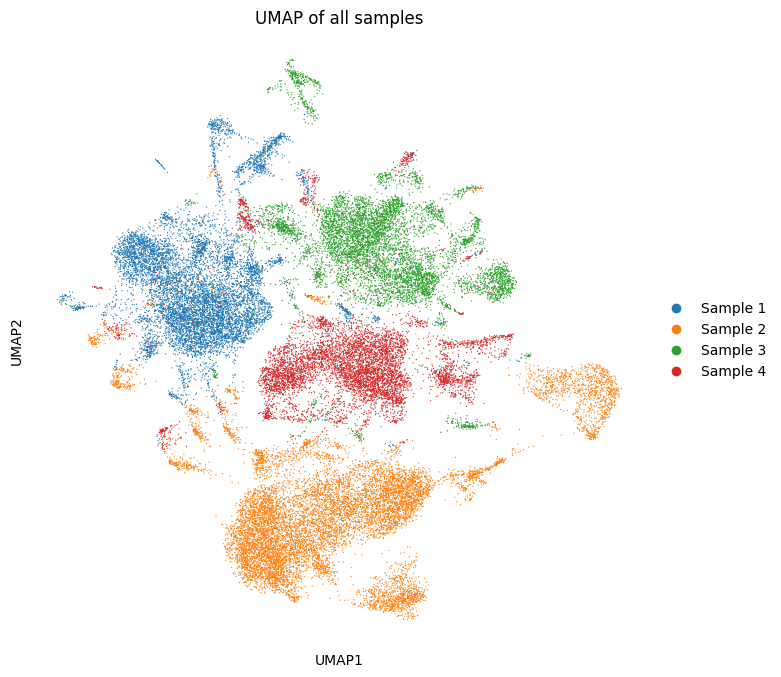

In [23]:
# 4 times

adata_combined = sc.read_h5ad('../data/merged.h5ad')
samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

before = adata_combined.X.copy()
for i in range(4):
    sc.pp.combat(adata_combined, key='sample', inplace=True)
after = adata_combined.X
print((before != after).sum())  # Count changes
adata_corr_umap2 = calc_umap(adata_combined)
plot_umap(adata_corr_umap2)

# Batch effects correction - scanpy scanorama

In [16]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')

samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

before = adata_combined.X
corrected_data_list = scanorama.correct_scanpy(adata_list, return_dimred=True)  # output will contain .obsm['X_scanorama']
# after = adata_combined.X
# print((before != after).sum())  # Count changes
adata_corrected = ad.concat(corrected_data_list) # Reconstruct the AnnData object
after = adata_corrected.X
print((before != after).sum())  # Count changes

Found 22000 genes among all datasets
[[0.         0.00413311 0.00979541 0.0023315 ]
 [0.         0.         0.         0.00252257]
 [0.         0.         0.         0.016739  ]
 [0.         0.         0.         0.        ]]


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/anndata/_core/anndata.py:796: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  getattr(self, attr).index = value


152102972


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


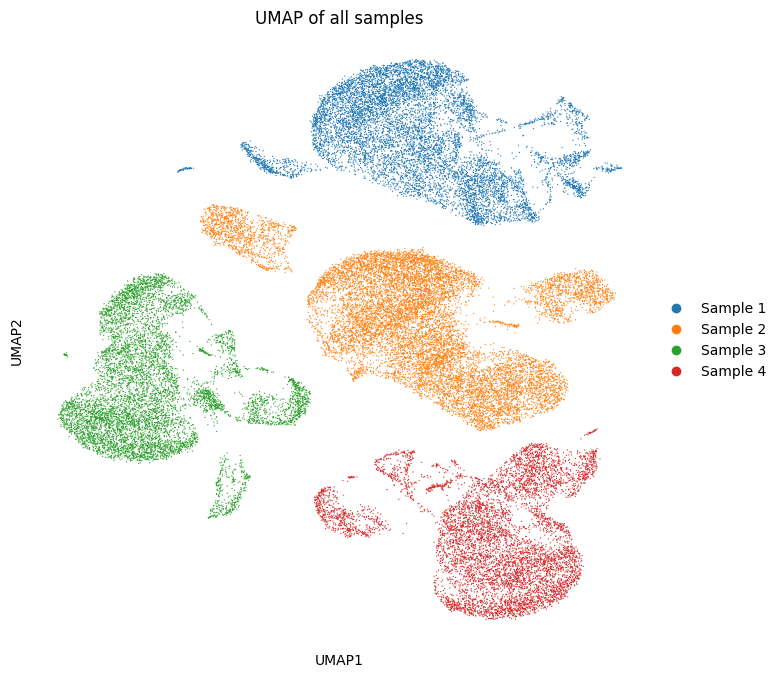

In [17]:
adata_corr_umap3 = calc_umap(adata_corrected)
plot_umap(adata_corr_umap3)

# Batch effects correction - scanpy MNN correct

In [ ]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')

samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]

before = adata_combined.X
adata_mnn_corrected, corrected_batches = mnn_correct(*adata_list, batch_key='batch')
# after = adata_combined.X
after = adata_corrected.X
print((before != after).sum())  # Count changes
adata_corr_umap3 = calc_umap(adata_corrected)
plot_umap(adata_corr_umap3)

# Batch effects correction - scanpy pycombat - no normalisation

/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Created PCA components in .obsm.X_pca


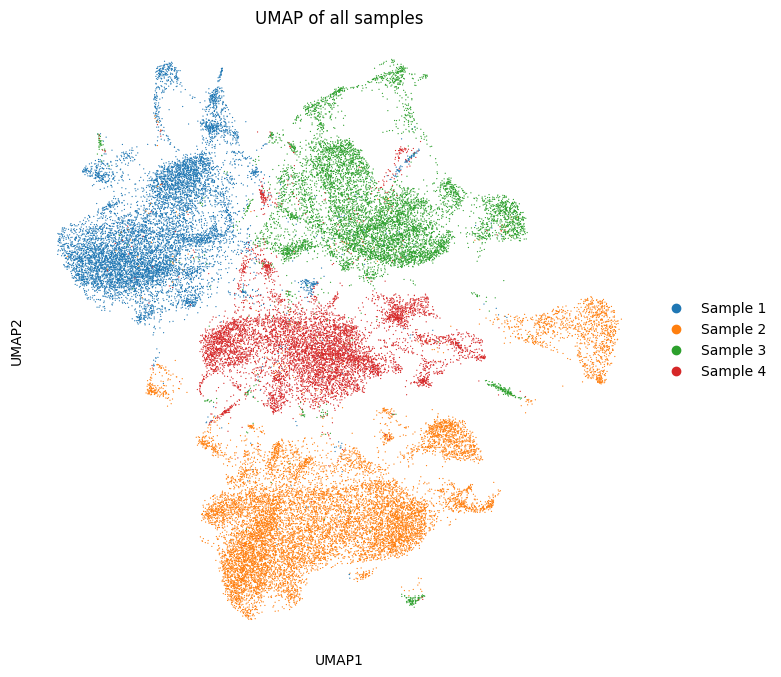

In [25]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')
samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]
adata_corrected = adata_combined.copy()
sc.pp.combat(adata_corrected, key='sample', inplace=True)
adata_corr_umap = calc_umap(adata_corrected)
plot_umap(adata_corr_umap)

# Batch effects correction - scanpy pycombat - with normalisation

Created PCA components in .obsm.X_pca


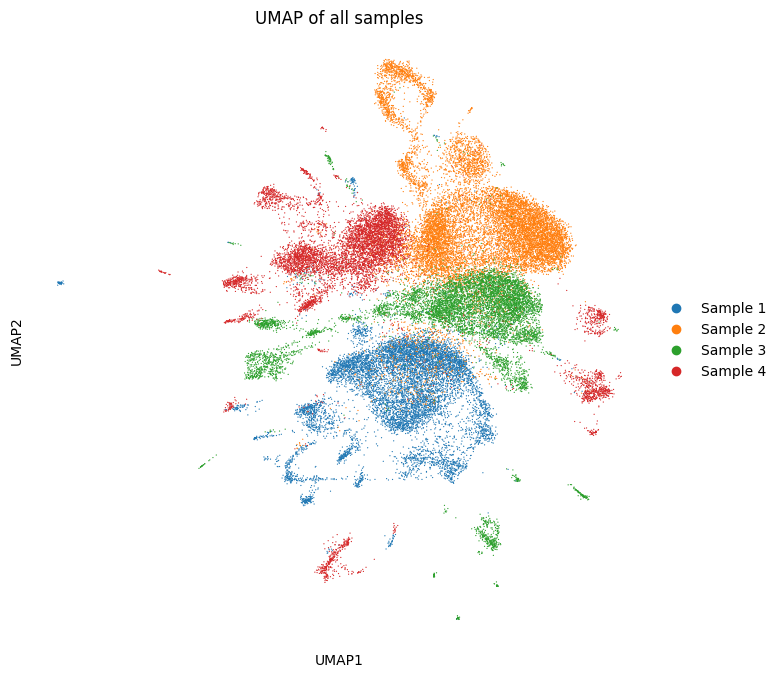

In [10]:
adata_combined = sc.read_h5ad('../data/merged.h5ad')
# Normalize and log-transform the raw counts
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)
samples = sorted(adata_combined.obs['sample'].unique())
adata_list = [adata_combined[adata_combined.obs['sample'] == sample] for sample in samples]
adata_corrected = adata_combined.copy()
sc.pp.combat(adata_corrected, key='sample', inplace=True)
adata_corr_umap = calc_umap(adata_corrected.copy())
plot_umap(adata_corr_umap)
adata_corrected.write_h5ad('../data/merged_batch_corrected.h5ad', compression='gzip')

In [117]:
Counter(merged_adata.obs['predicted.celltype'])

Counter({'CD4+ T cell': 21564,
         'Cytotoxic T cell': 12202,
         'B cell': 2449,
         'CD14+ monocyte': 996,
         'Natural killer cell': 821,
         'Megakaryocyte': 15,
         'Plasmacytoid dendritic cell': 3})

# Differential expression

In [87]:
weight_pow_thr = 0.5
cell_type_count_dict = {} # Used for penalizing pval adj
for i, sample in enumerate(samples):
    cnt = Counter(adata_list[i].obs['predicted.celltype'])
    cell_type_count_dict[sample] = cnt
    
# Subset for the four cell types of interest
cell_types = ['B cell', 'CD14+ monocyte', 'CD4+ T cell', 'Cytotoxic T cell', 'Natural killer cell']
adata_subset = adata_corrected[adata_corrected.obs['predicted.celltype'].isin(cell_types)].copy()

# Perform DE analysis for each cell type
results_all_degs = {ct: dict() for ct in cell_types}
results_significant_degs = {ct: dict() for ct in cell_types}
results_top_degs = {ct: dict() for ct in cell_types}
for cell_type in cell_types:
    cell_type_data = adata_subset[adata_subset.obs['predicted.celltype'] == cell_type]
    for sample in ['sample_1', 'sample_2', 'sample_3']:

        cell_type_data_sample = cell_type_data[cell_type_data.obs['sample'].isin([sample, 'sample_4'])]
        # sample_size = len(cell_type_data_sample[cell_type_data_sample.obs['sample'] == sample])
    
        # Perform DE analysis
        sc.tl.rank_genes_groups(cell_type_data_sample, groupby='sample', reference='sample_4', method='wilcoxon', pts=True)
    
        # Store results
        # Filter genes with significant adjusted p-value
        degs_df = sc.get.rank_genes_groups_df(cell_type_data_sample, group=sample)
        # Add penalty depending on the number of cells: 
        
        degs_df.loc[:, 'pvals_adj_weighted'] = degs_df['pvals_adj'] * np.pow(cell_type_count_dict[sample].most_common(1)[0][1],weight_pow_thr) / \
            np.pow(cell_type_count_dict[sample][cell_type], weight_pow_thr) 
        degs_df = degs_df[~degs_df['logfoldchanges'].isna()]
        degs_df.loc[:, 'logfoldchanges_abs'] = degs_df['logfoldchanges'].apply(abs)
        degs_df = degs_df.sort_values(by='logfoldchanges_abs', ascending=False) # Sort by log fold change or adjusted p-value
        significant_degs = degs_df[degs_df['pvals_adj'] < 0.05]  # Adjust threshold as needed
        top_degs = significant_degs[(significant_degs['logfoldchanges_abs'] > 1) ]

        results_all_degs[cell_type][sample] = degs_df
        results_significant_degs[cell_type][sample] = significant_degs
        results_top_degs[cell_type][sample] = top_degs
        print(len(significant_degs), len(top_degs))

# Save results
# for cell_type, df in results.items():
#     df.to_csv(f"DE_genes_{cell_type.replace(' ', '_')}.csv", index=False)

# print("Differentially expressed genes saved for each cell type.")


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


20192 5555


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


20620 5200


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


20204 5486


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


19389 5878


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


19641 5630


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


19142 5604


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


21517 1054


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


21502 1302


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


21432 1228


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


21481 2098


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


21551 2260


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


21425 2527


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


17989 6843


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:645: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


20039 5482
17171 6737


/root/miniconda3/envs/CoDi/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


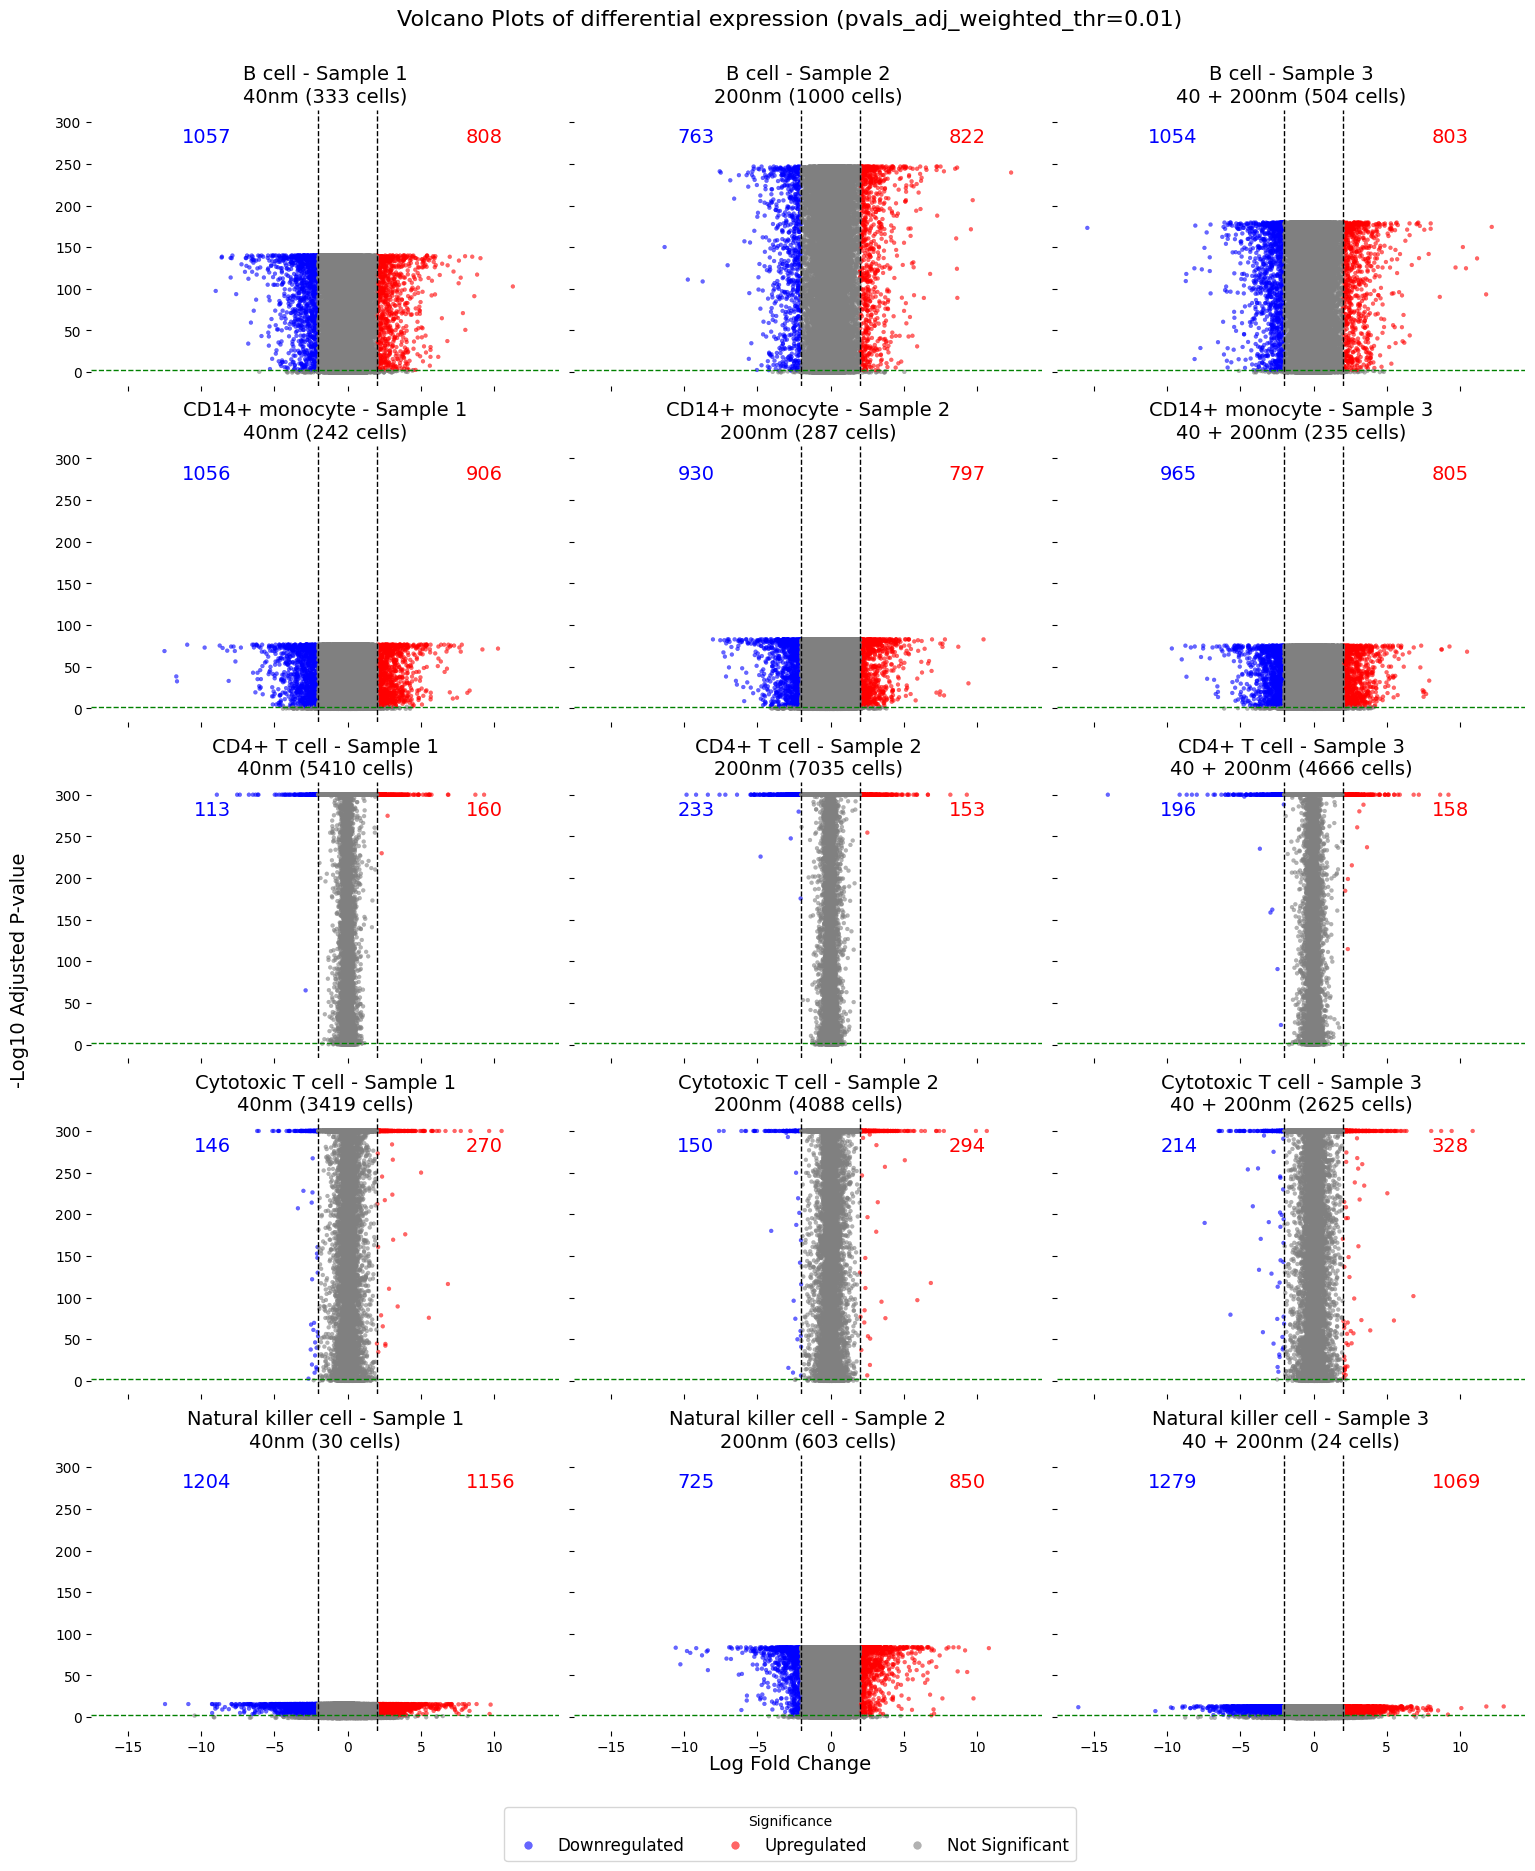

In [89]:
# Define thresholds for significant DEGs
logFC_threshold = 2
adj_p_value_threshold = 0.01
pval_adj_var = 'pvals_adj_weighted'

# Data structure keys
cell_types = list(results_all_degs.keys())
samples_desc = ['Sample 1\n40nm', 'Sample 2\n200nm', 'Sample 3\n40 + 200nm']

# Create a grid of subplots based on the dimensions of the data
n_rows = len(cell_types)
n_cols = len(samples_desc)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True, sharey=True)

# Iterate through cell types and samples
for i, cell_type in enumerate(cell_types):
    for j, sample in enumerate(samples_desc):
        ax = axes[i, j]
        
        # Access the dataframe for the current cell type and sample
        df = results_all_degs[cell_type][f"sample_{j + 1}"]
        
        # Add a column to classify genes based on thresholds
        df['significance'] = 'Not Significant'
        df.loc[((df['logfoldchanges'] >= logFC_threshold) & (df[pval_adj_var] < adj_p_value_threshold)), 'significance'] = 'Upregulated'
        df.loc[((df['logfoldchanges'] <= -logFC_threshold) & (df[pval_adj_var] < adj_p_value_threshold)), 'significance'] = 'Downregulated'
        df.loc[:, pval_adj_var] = df[pval_adj_var].apply(lambda x: x if x > 1e-300 else 1e-300)

        
        # Create the volcano plot for this subplot
        sns.scatterplot(
            data=df,
            x='logfoldchanges', 
            y=-np.log10(df[pval_adj_var]), 
            hue='significance',
            palette={'Not Significant': 'gray', 'Upregulated': 'red', 'Downregulated': 'blue'},
            alpha=0.6,
            s=8,
            edgecolor=None,
            ax=ax
        )
        
        # Add threshold lines
        ax.axvline(x=logFC_threshold, color='black', linestyle='--', linewidth=1)
        ax.axvline(x=-logFC_threshold, color='black', linestyle='--', linewidth=1)
        ax.axhline(y=-np.log10(adj_p_value_threshold), color='green', linestyle='--', linewidth=1)
        
        # Set subplot title to include current cell type and sample
        num_cells = len(adata_list[j][adata_list[j].obs['predicted.celltype'] == cell_type])
        ax.set_title(f"{cell_type} - {sample} ({num_cells} cells)", fontsize=14)
        ax.get_legend().remove()
        
        # Remove x and y labels for subplots
        ax.set_xlabel("")
        ax.set_ylabel("")

        # Remove frame around each subplot
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        
        # Annotate the number of upregulated and downregulated genes
        # Count the number of upregulated and downregulated genes
        upregulated_count = len(df[df['significance'] == 'Upregulated'])
        downregulated_count = len(df[df['significance'] == 'Downregulated'])
        ax.text(
            0.3, 0.9, f"{downregulated_count}", 
            color='blue', va='center', ha='right', fontsize=14,
            transform=ax.transAxes  # Use axes coordinates for consistent positioning
        )
        ax.text(
            0.8, 0.9, f"{upregulated_count}", 
            color='red', va='center', ha='left', fontsize=14,
            transform=ax.transAxes  # Use axes coordinates for consistent positioning
        )

# Add main x and y labels with adjusted positions
fig.text(0.5, 0.1, 'Log Fold Change', ha='center', fontsize=14)
fig.text(-0.02, 0.5, '-Log10 Adjusted P-value', va='center', rotation='vertical', fontsize=14)

# Adjust layout and add a single legend below the figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Significance', loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 0.05), markerscale=2)

plt.tight_layout(rect=[0, 0.1, 1, 0.96])  # Adjust lower space for legend
plt.suptitle(f"Volcano Plots of differential expression ({pval_adj_var}_thr={adj_p_value_threshold})", fontsize=16)
plt.savefig(f'volcano_{pval_adj_var}_{weight_pow_thr}.png', dpi=200, bbox_inches='tight')
plt.show()


2449


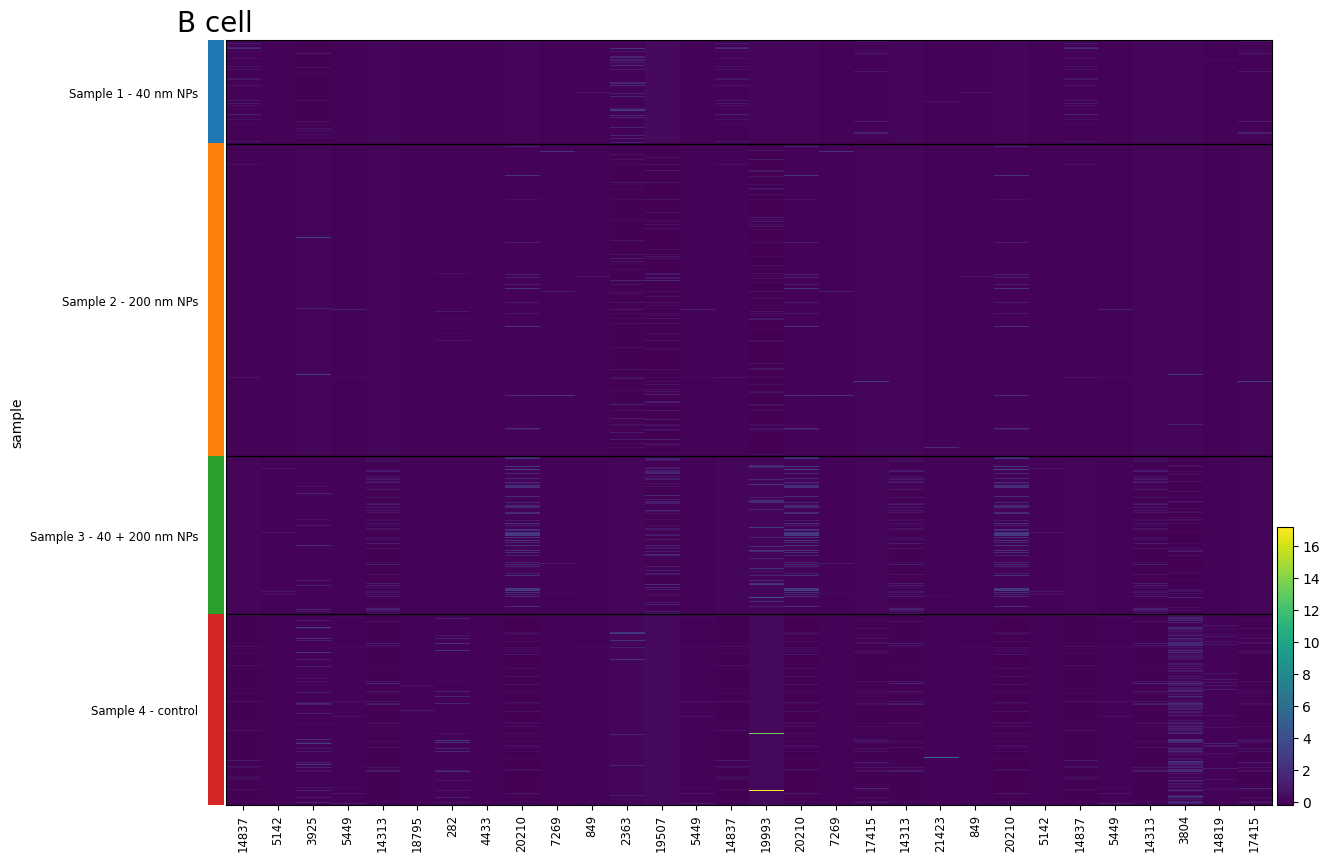

996


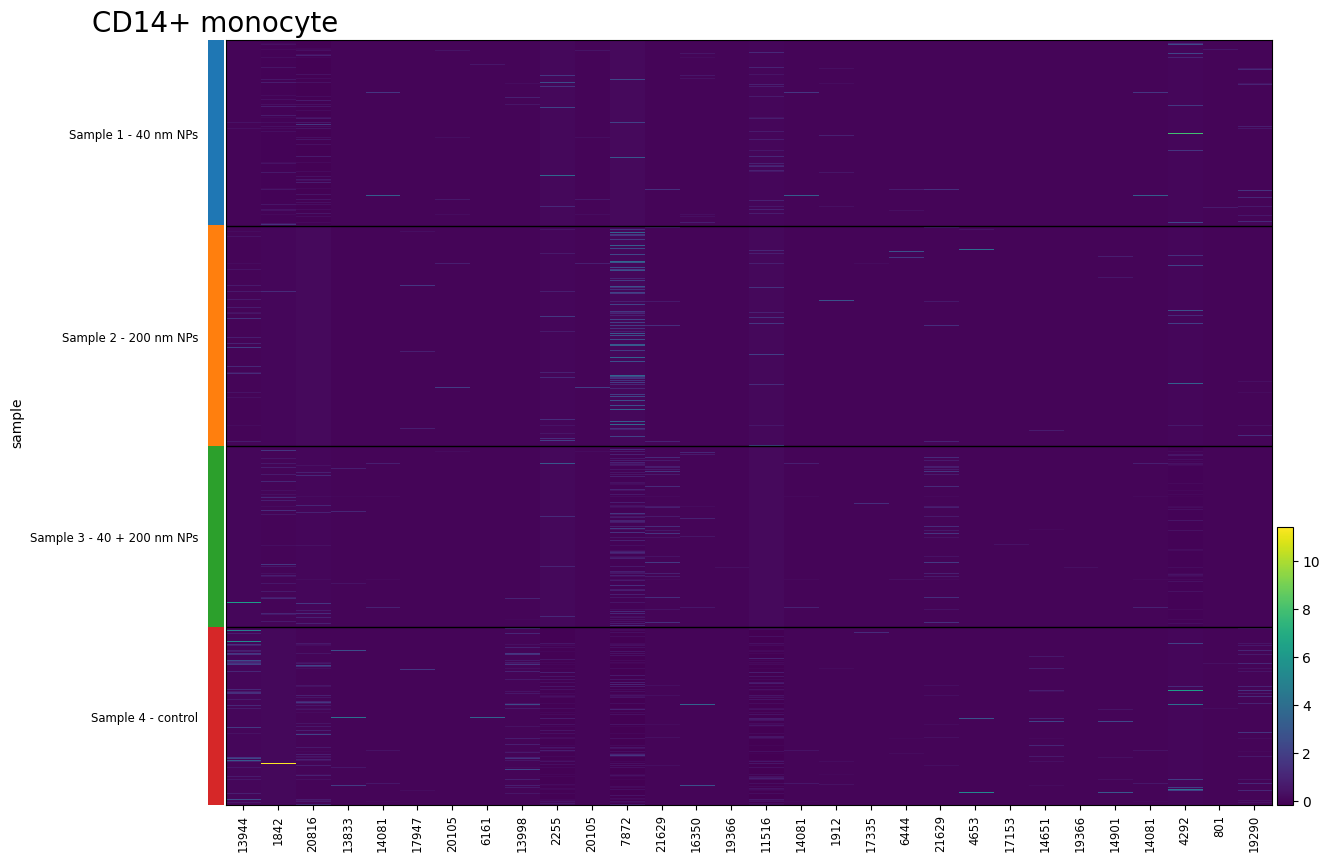

21564


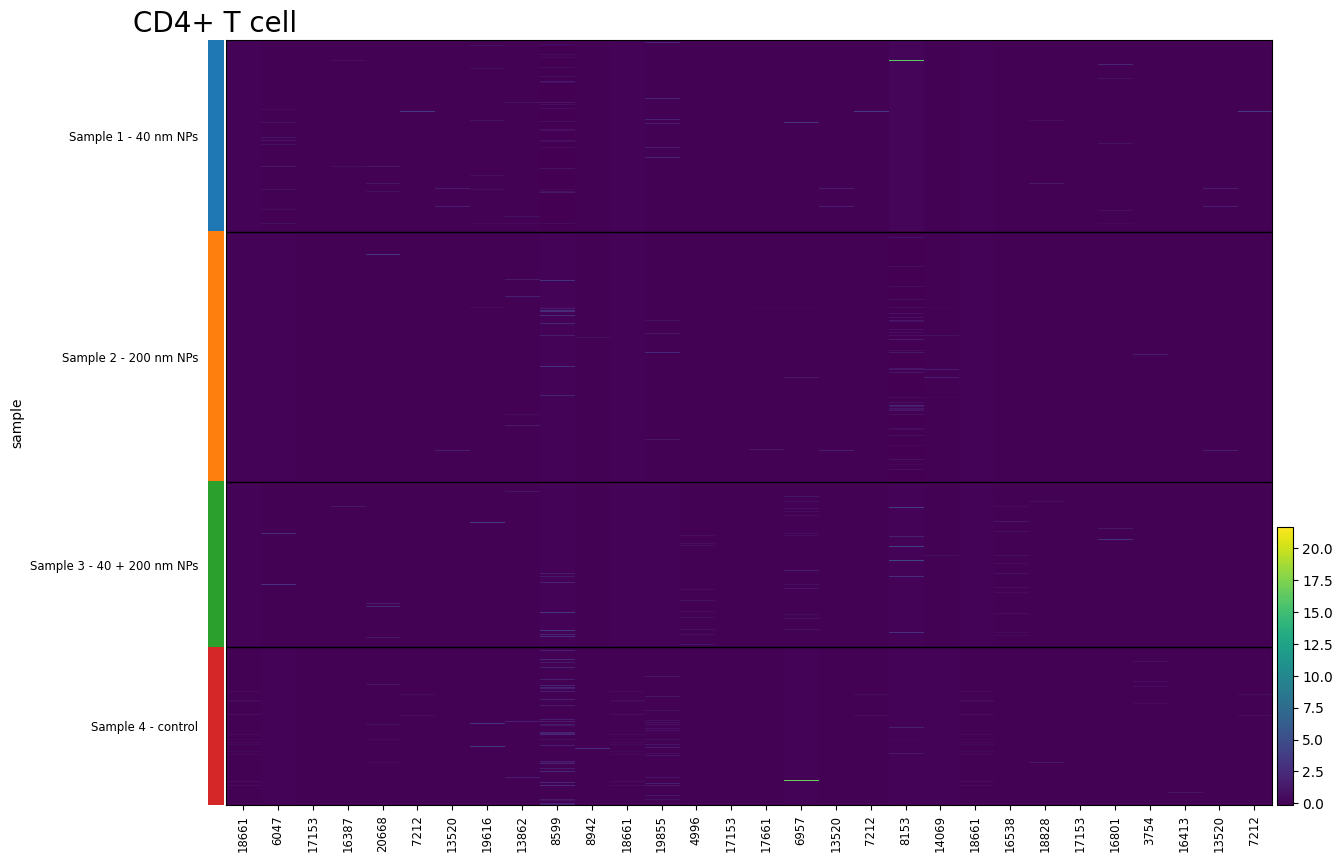

12202


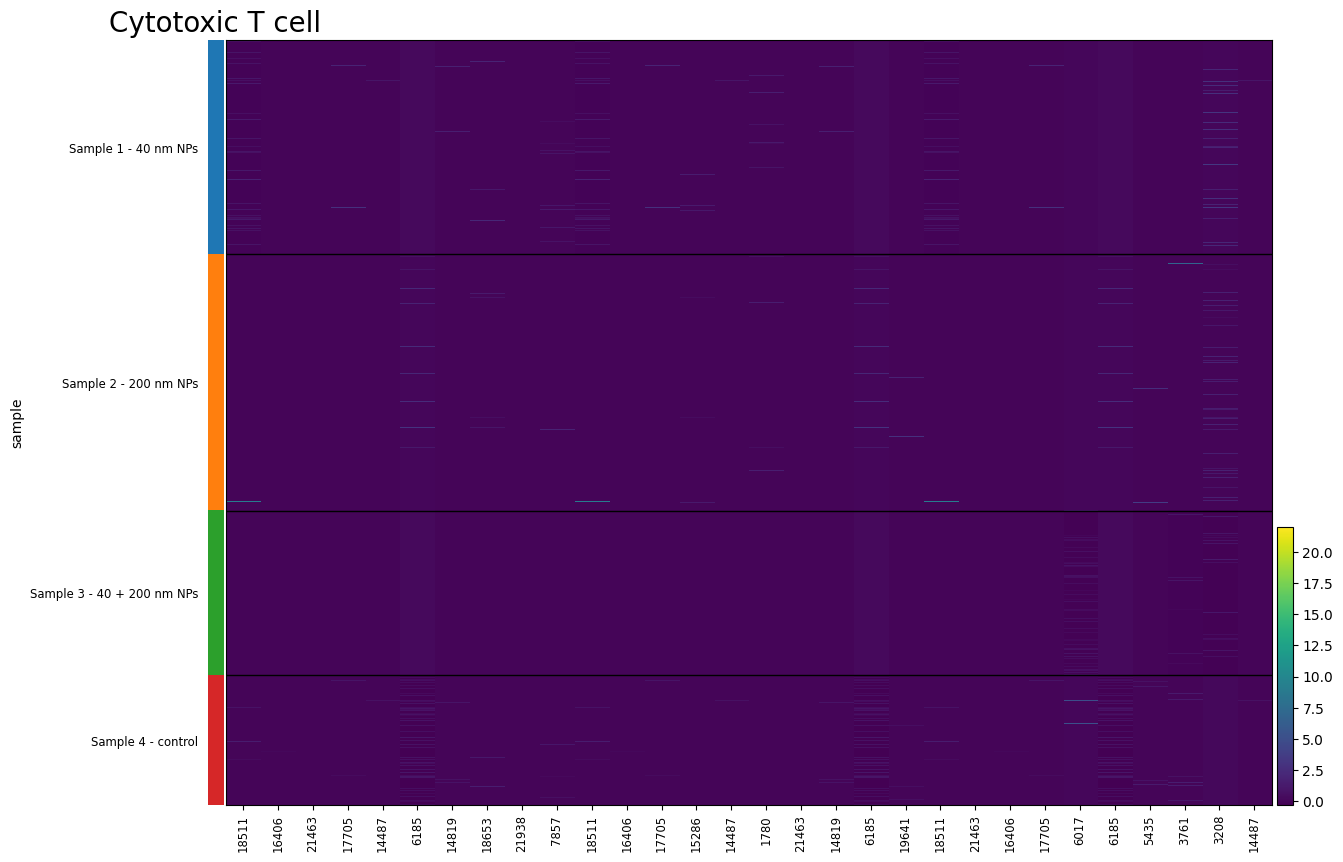

821


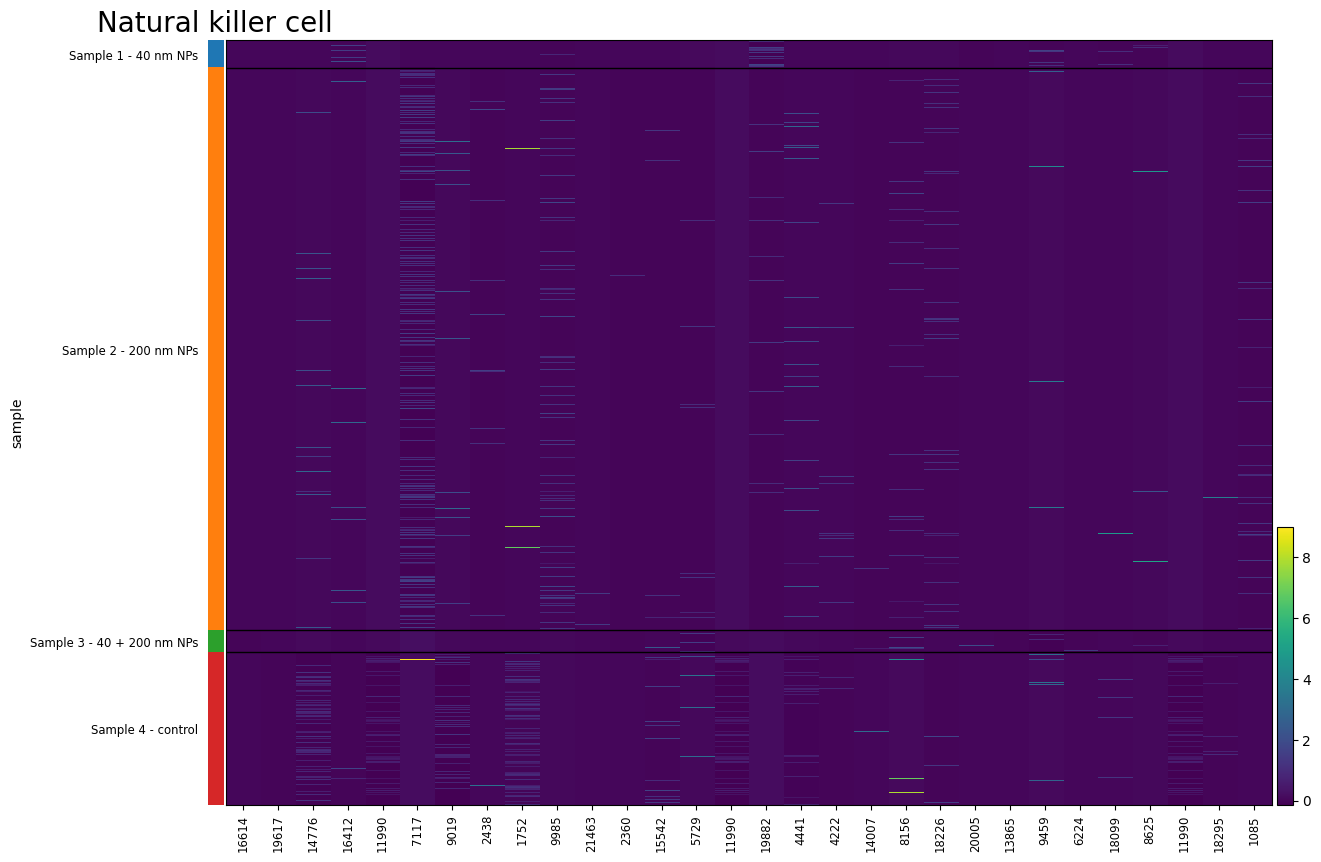

<Figure size 640x480 with 0 Axes>

In [45]:
# Create a figure for each cell type
# fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns for 4 subplots
# axes = axes.flatten()  # Flatten the 2x2 array into a 1D array for easier indexing
sample_names_dict = dict(zip(samples, sample_names))
# Loop through each cell type and plot in a subplot
for i, ct in enumerate(cell_types):
    # fig, axes = plt.subplots(1, 1, figsize=(14, 10))  # 2 rows, 2 columns for 4 subplots
    adata_subset = adata_corrected[adata_corrected.obs['predicted.celltype'].isin([ct])].copy()
    adata_subset.obs['sample'] = [sample_names_dict[sample] for sample in adata_subset.obs['sample']]
    print(len(adata_subset))

    # Plot heatmap for top genes
    top_genes_all = np.array([results_significant_degs[ct][sample].head(10)['names'] for sample in samples[:-1]]).flatten()
    sc.pl.heatmap(
        adata_subset, 
        var_names=top_genes_all,
        groupby='sample', 
        use_raw=False,
        figsize=(14, 10),
        show=False,  # Prevent automatic display
    )
    plt.title(ct, fontsize = 20)
    plt.savefig(f'heatmap_{ct}.png', dpi=150, bbox_inches='tight')
    plt.show()
    # axes[i].set_title(ct)  # Set the title for each subplot

# Adjust layout for better spacing
plt.tight_layout()

In [26]:
for i, ct in enumerate(cell_types):
    for sample in ['sample_1', 'sample_2', 'sample_3']:
        display(results_significant_degs[ct][sample].head(10))

names     scores  logfoldchanges          pvals      pvals_adj  \
4224   14837  21.714815       11.283755  1.486408e-104  3.710539e-104   
1333    5142  25.090868        9.071005  6.256584e-139  4.342782e-138   
17099   3925 -21.132513       -9.001547   3.996978e-99   9.339725e-99   
3429    5449  23.179052        8.842124  7.407661e-119  2.278643e-118   
4827   14313  20.437443        8.649762   7.770441e-93   1.703535e-92   
1122   18795  25.172949       -8.600611  7.925689e-140  6.657700e-139   
21266    282 -25.277983       -8.575612  5.579033e-141  7.424915e-140   
20848   4433 -25.269501        8.508098  6.915296e-141  7.424915e-140   
6815   20210  15.203464        8.037775   3.354058e-52   5.299050e-52   
351     7269  25.339855        8.021301  1.162587e-141  1.787887e-140   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
4224            1.0       6.028234e-103           11.283755  
1333            1.0       7.055391e-137            9.071005  
17099           1.0        1.517355e-97            9.001547  
3429            1.0       3.701939e-117            8.842124  
4827            1.0        2.767604e-91            8.649762  
1122            1.0       1.081626e-137            8.600611  
21266           1.0       1.206270e-138            8.575612  
20848           1.0       1.206270e-138            8.508098  
6815            1.0        8.608967e-51            8.037775  
351             1.0       2.904646e-139            8.021301

names     scores  logfoldchanges          pvals      pvals_adj  \
1712     849  33.191120       12.326024  1.445909e-241  1.026792e-240   
17300   2363 -26.228970      -11.329097  1.242148e-151  2.718589e-151   
16253  19507 -22.536974       -9.743004  1.802200e-112  3.252535e-112   
3676    5449  30.783266        9.706165  4.389195e-208  1.426959e-207   
4740   14837  28.041008        9.582930  5.142021e-173  1.272777e-172   
16197  19993 -22.304558       -8.729895  3.337213e-110  5.960760e-110   
7080   20210  20.168921        8.654384   1.836012e-90   3.008510e-90   
397     7269  33.629276        8.642529  6.264952e-248  1.173637e-246   
6071   17415  23.824972        8.628401  1.840824e-125  3.532942e-125   
5055   14313  27.122694        8.575733  5.317400e-162  1.233085e-161   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
1712            1.0       1.668151e-239           12.326024  
17300           1.0       4.416686e-150           11.329097  
16253           1.0       5.284148e-111            9.743004  
3676            1.0       2.318272e-206            9.706165  
4740            1.0       2.067786e-171            9.582930  
16197           1.0       9.683997e-109            8.729895  
7080            1.0        4.887700e-89            8.654384  
397             1.0       1.906720e-245            8.642529  
6071            1.0       5.739705e-124            8.628401  
5055            1.0       2.003301e-160            8.575733

names     scores  logfoldchanges          pvals      pvals_adj  \
20179  21423 -28.213617      -15.443934  3.980574e-175  2.458524e-174   
1468     849  28.312902       12.168709  2.397394e-176  1.607016e-175   
5450   20210  20.659729       11.783809   7.981247e-95   1.536198e-94   
17774   5142 -25.018387       11.165771  3.857017e-138  1.046422e-137   
4328   14837  23.900869       10.409286  2.999700e-126  7.276812e-126   
3269    5449  26.247696       10.196918  7.594007e-152  2.434686e-151   
4286   14313  23.991570        9.696064  3.405496e-127  8.328248e-127   
16676   3804 -22.368479       -8.718480  7.981122e-111  1.717210e-110   
4591   14819  23.232746       -8.686780  2.125870e-119  4.878393e-119   
5572   17415  20.316895        8.620860   9.116234e-92   1.720044e-91   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
20179           1.0       3.994178e-173           15.443934  
1468            1.0       2.610798e-174           12.168709  
5450            1.0        2.495745e-93           11.783809  
17774           1.0       1.700043e-136           11.165771  
4328            1.0       1.182209e-124           10.409286  
3269            1.0       3.955451e-150           10.196918  
4286            1.0       1.353028e-125            9.696064  
16676           1.0       2.789821e-109            8.718480  
4591            1.0       7.925557e-118            8.686780  
5572            1.0        2.794426e-90            8.620860

names     scores  logfoldchanges         pvals     pvals_adj  \
19689  13944 -17.796288      -12.501220  7.551287e-71  3.626464e-70   
17005   1842 -13.252297      -11.695269  4.376015e-40  9.992976e-40   
16542  20816 -12.193777      -11.645675  3.355040e-34  7.040335e-34   
21878  13833 -18.830658      -10.949783  4.234656e-79  8.438626e-78   
1694   14081  18.190716       10.269214  6.113601e-74  3.713397e-73   
1556   17947  18.343658       -9.758080  3.709720e-75  2.420339e-74   
19929  20105 -18.052532        9.204245  7.535599e-73  4.098472e-72   
21298   6161 -18.675703       -8.729251  7.805455e-78  9.447237e-77   
20302  13998 -18.285969       -8.532271  1.070430e-74  6.979683e-74   
5962    2255   9.878181        8.331630  5.176446e-23  9.199597e-23   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
19689           1.0        8.107095e-69           12.501220  
17005           1.0        2.233967e-38           11.695269  
16542           1.0        1.573893e-32           11.645675  
21878           1.0        1.886486e-76           10.949783  
1694            1.0        8.301437e-72           10.269214  
1556            1.0        5.410759e-73            9.758080  
19929           1.0        9.162286e-71            9.204245  
21298           1.0        2.111965e-75            8.729251  
20302           1.0        1.560334e-72            8.532271  
5962            1.0        2.056604e-21            8.331630

names     scores  logfoldchanges         pvals     pvals_adj  \
296    20105  19.599451       10.443768  1.563025e-85  3.151837e-84   
5622    7872  11.725408        9.413321  9.444578e-32  1.832928e-31   
2490   21629  18.449694        8.720287  5.244212e-76  2.365163e-75   
21804  16350 -19.599451       -8.029058  1.563025e-85  3.151837e-84   
389    19366  19.599451        7.808629  1.563025e-85  3.151837e-84   
7111   11516   8.421547        7.748558  3.715455e-17  5.807873e-17   
2110   14081  18.923607        7.643588  7.289054e-80  4.100209e-79   
2554    1912  18.420847        7.642462  8.939522e-76  3.961916e-75   
21411  17335 -19.463457       -7.530226  2.241403e-84  3.247437e-83   
1915    6444  18.930672        7.491954  6.374404e-80  3.826382e-79   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
296             1.0        7.046048e-83           10.443768  
5622            1.0        4.097579e-30            9.413321  
2490            1.0        5.287410e-74            8.720287  
21804           1.0        7.046048e-83            8.029058  
389             1.0        7.046048e-83            7.808629  
7111            1.0        1.298372e-15            7.748558  
2110            1.0        9.166170e-78            7.643588  
2554            1.0        8.857010e-74            7.642462  
21411           1.0        7.259766e-82            7.530226  
1915            1.0        8.554018e-78            7.491954

names     scores  logfoldchanges         pvals     pvals_adj  \
2135   21629  17.695383       10.482780  4.551228e-70  2.343249e-69   
20676   4653 -18.221382       -9.672292  3.492187e-74  2.904198e-73   
21164  17153 -18.535473        9.282084  1.068453e-76  1.309507e-75   
3009   14651  16.439020       -8.994867  1.005314e-60  3.679405e-60   
20259  19366 -18.058165        8.758935  6.804715e-73  4.434352e-72   
21919  14901 -18.694576       -8.746189  5.480419e-78  1.282651e-76   
1617   14081  18.056793        8.729131  6.975879e-73  4.536487e-72   
17652   4292 -13.189072       -8.674440  1.014267e-39  2.543762e-39   
1162     801  18.372255       -8.375730  2.191123e-75  1.872027e-74   
21503  19290 -18.554676       -8.108797  7.475746e-77  1.309507e-75   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
2135            1.0        5.238420e-68           10.482780  
20676           1.0        6.492442e-72            9.672292  
21164           1.0        2.927452e-74            9.282084  
3009            1.0        8.225447e-59            8.994867  
20259           1.0        9.913159e-71            8.758935  
21919           1.0        2.867415e-75            8.746189  
1617            1.0        1.014148e-70            8.729131  
17652           1.0        5.686675e-38            8.674440  
1162            1.0        4.184986e-73            8.375730  
21503           1.0        2.927452e-74            8.108797

names     scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
5760   18661  67.227333        9.318686    0.0        0.0           1.0   
17688   6047 -76.108162       -8.924773    0.0        0.0           1.0   
21     17153  85.597107        8.723270    0.0        0.0           1.0   
19026  16387 -81.677292       -7.539426    0.0        0.0           1.0   
19670  20668 -83.331543       -7.357179    0.0        0.0           1.0   
2657    7212  83.100975        6.881961    0.0        0.0           1.0   
1871   13520  84.370316        6.849391    0.0        0.0           1.0   
18239  19616 -78.780907       -6.739368    0.0        0.0           1.0   
19976  13862 -83.872513       -6.466985    0.0        0.0           1.0   
16146   8599 -65.789429       -6.284849    0.0        0.0           1.0   

       pvals_adj_weighted  logfoldchanges_abs  
5760                  0.0            9.318686  
17688                 0.0            8.924773  
21                    0.0            8.723270  
19026                 0.0            7.539426  
19670                 0.0            7.357179  
2657                  0.0            6.881961  
1871                  0.0            6.849391  
18239                 0.0            6.739368  
19976                 0.0            6.466985  
16146                 0.0            6.284849

names     scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
20004   8942 -88.730042       -9.831065    0.0        0.0           1.0   
6057   18661  71.040375        9.303195    0.0        0.0           1.0   
5781   19855  72.959381       -9.180776    0.0        0.0           1.0   
21652   4996 -90.263718       -8.374784    0.0        0.0           1.0   
2      17153  90.443611        8.178123    0.0        0.0           1.0   
20848  17661 -89.751442       -7.579173    0.0        0.0           1.0   
20491   6957 -89.441467       -7.182273    0.0        0.0           1.0   
2112   13520  89.147224        6.650457    0.0        0.0           1.0   
2880    7212  87.808060        6.642487    0.0        0.0           1.0   
16597   8153 -72.106308       -6.385175    0.0        0.0           1.0   

       pvals_adj_weighted  logfoldchanges_abs  
20004                 0.0            9.831065  
6057                  0.0            9.303195  
5781                  0.0            9.180776  
21652                 0.0            8.374784  
2                     0.0            8.178123  
20848                 0.0            7.579173  
20491                 0.0            7.182273  
2112                  0.0            6.650457  
2880                  0.0            6.642487  
16597                 0.0            6.385175

names     scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
19130  14069 -79.060570      -14.041294    0.0        0.0           1.0   
5492   18661  64.927742        9.214505    0.0        0.0           1.0   
17851  16538 -73.484650       -9.138606    0.0        0.0           1.0   
19043  18828 -78.755356       -8.657388    0.0        0.0           1.0   
21716  17153 -82.530914        8.644607    0.0        0.0           1.0   
19399  16801 -79.840309       -8.303385    0.0        0.0           1.0   
2675    3754  80.002213       -7.968800    0.0        0.0           1.0   
21629  16413 -82.460381       -7.231446    0.0        0.0           1.0   
1770   13520  81.486427        7.188408    0.0        0.0           1.0   
2557    7212  80.263245        6.837287    0.0        0.0           1.0   

       pvals_adj_weighted  logfoldchanges_abs  
19130                 0.0           14.041294  
5492                  0.0            9.214505  
17851                 0.0            9.138606  
19043                 0.0            8.657388  
21716                 0.0            8.644607  
19399                 0.0            8.303385  
2675                  0.0            7.968800  
21629                 0.0            7.231446  
1770                  0.0            7.188408  
2557                  0.0            6.837287

names     scores  logfoldchanges          pvals      pvals_adj  \
16071  18511 -47.695370       10.513800   0.000000e+00   0.000000e+00   
2441   16406  60.926949        9.664360   0.000000e+00   0.000000e+00   
89     21463  62.188370        8.386927   0.000000e+00   0.000000e+00   
3293   17705  59.551502        7.730701   0.000000e+00   0.000000e+00   
1769   14487  61.528591        7.307028   0.000000e+00   0.000000e+00   
9647    6185  23.012701        6.850203  3.478238e-117  4.149516e-117   
1665   14819  61.589890        6.683832   0.000000e+00   0.000000e+00   
1331   18653  61.770744        6.249966   0.000000e+00   0.000000e+00   
21961  21938 -62.152081       -6.172550   0.000000e+00   0.000000e+00   
2166    7857  61.182507        6.086358   0.000000e+00   0.000000e+00   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
16071           1.0        0.000000e+00           10.513800  
2441            1.0        0.000000e+00            9.664360  
89              1.0        0.000000e+00            8.386927  
3293            1.0        0.000000e+00            7.730701  
1769            1.0        0.000000e+00            7.307028  
9647            1.0       6.565921e-117            6.850203  
1665            1.0        0.000000e+00            6.683832  
1331            1.0        0.000000e+00            6.249966  
21961           1.0        0.000000e+00            6.172550  
2166            1.0        0.000000e+00            6.086358

names     scores  logfoldchanges          pvals      pvals_adj  \
3526   18511  61.480976       10.668109   0.000000e+00   0.000000e+00   
2664   16406  62.899319        9.927362   0.000000e+00   0.000000e+00   
3542   17705  61.472298        7.737709   0.000000e+00   0.000000e+00   
19932  15286 -62.727234       -7.612110   0.000000e+00   0.000000e+00   
2009   14487  63.519474        7.426172   0.000000e+00   0.000000e+00   
20294   1780 -63.203297       -7.296090   0.000000e+00   0.000000e+00   
21940  21463 -64.170235        7.233946   0.000000e+00   0.000000e+00   
1868   14819  63.582977        7.205294   0.000000e+00   0.000000e+00   
10007   6185  23.135931        6.847200  2.014423e-118  2.377410e-118   
4491   19641  58.582794        6.444523   0.000000e+00   0.000000e+00   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
3526            1.0        0.000000e+00           10.668109  
2664            1.0        0.000000e+00            9.927362  
3542            1.0        0.000000e+00            7.737709  
19932           1.0        0.000000e+00            7.612110  
2009            1.0        0.000000e+00            7.426172  
20294           1.0        0.000000e+00            7.296090  
21940           1.0        0.000000e+00            7.233946  
1868            1.0        0.000000e+00            7.205294  
10007           1.0       3.761857e-118            6.847200  
4491            1.0        0.000000e+00            6.444523

names     scores  logfoldchanges          pvals      pvals_adj  \
3102   18511  56.427380       10.866981   0.000000e+00   0.000000e+00   
21370  21463 -58.738224        9.430097   0.000000e+00   0.000000e+00   
2301   16406  57.722351        8.714157   0.000000e+00   0.000000e+00   
3109   17705  56.417839        8.033852   0.000000e+00   0.000000e+00   
13899   6017 -29.446346       -7.432423  1.402108e-190  1.860681e-190   
9332    6185  21.517799        6.818093  1.060784e-102  1.281421e-102   
3193    5435  56.247169       -6.485879   0.000000e+00   0.000000e+00   
17838   3761 -52.407448       -6.420592   0.000000e+00   0.000000e+00   
15832   3208 -43.065201       -6.399158   0.000000e+00   0.000000e+00   
1723   14487  58.291607        6.344232   0.000000e+00   0.000000e+00   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
3102            1.0        0.000000e+00           10.866981  
21370           1.0        0.000000e+00            9.430097  
2301            1.0        0.000000e+00            8.714157  
3109            1.0        0.000000e+00            8.033852  
13899           1.0       2.944220e-190            7.432423  
9332            1.0       2.027637e-102            6.818093  
3193            1.0        0.000000e+00            6.485879  
17838           1.0        0.000000e+00            6.420592  
15832           1.0        0.000000e+00            6.399158  
1723            1.0        0.000000e+00            6.344232

names    scores  logfoldchanges         pvals     pvals_adj  \
19630  16614 -8.700132      -12.463041  3.314965e-18  1.525397e-17   
1328   19617  8.700132      -10.872266  3.314965e-18  1.525397e-17   
9557   14776  3.289074      -10.446591  1.005174e-03  1.202100e-03   
2546   16412  8.505617        9.764737  1.806316e-17  7.064704e-17   
8671   11990  4.456165        9.695758  8.343863e-06  1.094799e-05   
19965   7117 -8.700132       -9.258089  3.314965e-18  1.525397e-17   
8267    9019  4.986661       -9.247604  6.143159e-07  8.497297e-07   
19848   2438 -8.700132       -9.240538  3.314965e-18  1.525397e-17   
10349   1752  2.015884       -9.137113  4.381207e-02  4.843788e-02   
18023   9985 -8.120124       -9.061710  4.657084e-16  1.219567e-15   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
19630           1.0        2.750799e-15           12.463041  
1328            1.0        2.750799e-15           10.872266  
9557            1.0        2.167787e-01           10.446591  
2546            1.0        1.274002e-14            9.764737  
8671            1.0        1.974288e-03            9.695758  
19965           1.0        2.750799e-15            9.258089  
8267            1.0        1.532346e-04            9.247604  
19848           1.0        2.750799e-15            9.240538  
10349           1.0        8.734965e+00            9.137113  
18023           1.0        2.199287e-13            9.061710

names     scores  logfoldchanges         pvals     pvals_adj  \
20626  21463 -19.524059       10.808212  6.856870e-85  4.540973e-84   
21213   2360 -19.589247      -10.569749  1.909916e-85  1.424344e-84   
5350   15542  17.025021      -10.252987  5.357358e-65  1.170775e-64   
19393   5729 -19.081650       -9.803993  3.587583e-81  1.336157e-80   
8908   11990  10.066907        9.757914  7.737347e-24  1.003784e-23   
18945  19882 -18.806982       -9.577412  6.620149e-79  2.157039e-78   
6216    4441  15.719654        9.328086  1.109282e-55  2.068854e-55   
2771    4222  19.182215        9.184113  5.211247e-82  2.182098e-81   
20848  14007 -19.524855       -9.171561  6.750988e-85  4.540973e-84   
18521   8156 -18.438505       -8.775091  6.449938e-76  1.838065e-75   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
20626           1.0        8.188888e-82           10.808212  
21213           1.0        2.568567e-82           10.569749  
5350            1.0        2.111297e-62           10.252987  
19393           1.0        2.409537e-78            9.803993  
8908            1.0        1.810157e-21            9.757914  
18945           1.0        3.889860e-76            9.577412  
6216            1.0        3.730833e-53            9.328086  
2771            1.0        3.935050e-79            9.184113  
20848           1.0        8.188888e-82            9.171561  
18521           1.0        3.314644e-73            8.775091

names    scores  logfoldchanges         pvals     pvals_adj  \
3098   18226  7.615011      -16.058275  2.636699e-14  8.703284e-14   
1526   20005  7.904188       12.985469  2.696854e-15  1.185904e-14   
21523  13865 -7.904188       11.796688  2.696854e-15  1.185904e-14   
16133   9459 -5.988387      -10.797237  2.119330e-09  3.867391e-09   
17643   6224 -7.245506       10.088899  4.308283e-13  1.073411e-12   
3359   18099  7.518618       -9.736697  5.535827e-14  1.749579e-13   
17583   8625 -7.245506       -9.610799  4.308283e-13  1.073411e-12   
8336   11990  4.048487        9.178723  5.154988e-05  6.936800e-05   
3690   18295  7.422225       -8.943226  1.151685e-13  3.512209e-13   
21130   1085 -7.904188       -8.938727  2.696854e-15  1.185904e-14   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
3098            1.0        1.569492e-11           16.058275  
1526            1.0        2.138581e-12           12.985469  
21523           1.0        2.138581e-12           11.796688  
16133           1.0        6.974195e-07           10.797237  
17643           1.0        1.935719e-10           10.088899  
3359            1.0        3.155074e-11            9.736697  
17583           1.0        1.935719e-10            9.610799  
8336            1.0        1.250936e-02            9.178723  
3690            1.0        6.333684e-11            8.943226  
21130           1.0        2.138581e-12            8.938727

In [27]:
for i, ct in enumerate(cell_types):
    for sample in ['sample_1', 'sample_2', 'sample_3']:
        df = results_significant_degs[ct][sample]
        display(df[df['logfoldchanges_abs'] > 1])

names     scores  logfoldchanges          pvals      pvals_adj  \
4224   14837  21.714815       11.283755  1.486408e-104  3.710539e-104   
1333    5142  25.090868        9.071005  6.256584e-139  4.342782e-138   
17099   3925 -21.132513       -9.001547   3.996978e-99   9.339725e-99   
3429    5449  23.179052        8.842124  7.407661e-119  2.278643e-118   
4827   14313  20.437443        8.649762   7.770441e-93   1.703535e-92   
...      ...        ...             ...            ...            ...   
7978   21557  11.612603       -1.000985   3.556207e-31   4.874247e-31   
7369    6151  13.541883       -1.000954   8.849082e-42   1.300466e-41   
16266  20613 -19.182526       -1.000571   5.180175e-82   1.029856e-81   
18824   6288 -23.910297       -1.000077  2.393437e-126  8.630653e-126   
12194  16107  -4.398698       -1.000015   1.089021e-05   1.204609e-05   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
4224            1.0       6.028234e-103           11.283755  
1333            1.0       7.055391e-137            9.071005  
17099           1.0        1.517355e-97            9.001547  
3429            1.0       3.701939e-117            8.842124  
4827            1.0        2.767604e-91            8.649762  
...             ...                 ...                 ...  
7978            1.0        7.918822e-30            1.000985  
7369            1.0        2.112770e-40            1.000954  
16266           1.0        1.673129e-80            1.000571  
18824           1.0       1.402157e-124            1.000077  
12194           1.0        1.957037e-04            1.000015  

[5555 rows x 8 columns]

names     scores  logfoldchanges          pvals      pvals_adj  \
1712     849  33.191120       12.326024  1.445909e-241  1.026792e-240   
17300   2363 -26.228970      -11.329097  1.242148e-151  2.718589e-151   
16253  19507 -22.536974       -9.743004  1.802200e-112  3.252535e-112   
3676    5449  30.783266        9.706165  4.389195e-208  1.426959e-207   
4740   14837  28.041008        9.582930  5.142021e-173  1.272777e-172   
...      ...        ...             ...            ...            ...   
17761    422 -27.761511       -1.000533  1.265402e-169  3.061905e-169   
14079  12237 -12.894416        1.000497   4.839168e-38   6.369612e-38   
2431   13118  32.746574       -1.000381  3.397055e-235  1.738028e-234   
10294    485   6.089927       -1.000299   1.129622e-09   1.269238e-09   
4925   10520  27.491167        1.000036  2.239012e-166  5.329252e-166   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
1712            1.0       1.668151e-239           12.326024  
17300           1.0       4.416686e-150           11.329097  
16253           1.0       5.284148e-111            9.743004  
3676            1.0       2.318272e-206            9.706165  
4740            1.0       2.067786e-171            9.582930  
...             ...                 ...                 ...  
17761           1.0       4.974446e-168            1.000533  
14079           1.0        1.034823e-36            1.000497  
2431            1.0       2.823643e-233            1.000381  
10294           1.0        2.062035e-08            1.000299  
4925            1.0       8.658033e-165            1.000036  

[5200 rows x 8 columns]

names     scores  logfoldchanges          pvals      pvals_adj  \
20179  21423 -28.213617      -15.443934  3.980574e-175  2.458524e-174   
1468     849  28.312902       12.168709  2.397394e-176  1.607016e-175   
5450   20210  20.659729       11.783809   7.981247e-95   1.536198e-94   
17774   5142 -25.018387       11.165771  3.857017e-138  1.046422e-137   
4328   14837  23.900869       10.409286  2.999700e-126  7.276812e-126   
...      ...        ...             ...            ...            ...   
12163   7512  -5.482337        1.000588   4.197440e-08   4.746283e-08   
18896   9750 -26.972738       -1.000438  3.087317e-160  1.132016e-159   
2145     134  27.845404        1.000288  1.224410e-170  5.945048e-170   
4211    1783  24.189392        1.000275  2.876869e-129  7.175050e-129   
12786  16234  -8.143069        1.000191   3.853815e-16   4.659226e-16   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
20179           1.0       3.994178e-173           15.443934  
1468            1.0       2.610798e-174           12.168709  
5450            1.0        2.495745e-93           11.783809  
17774           1.0       1.700043e-136           11.165771  
4328            1.0       1.182209e-124           10.409286  
...             ...                 ...                 ...  
12163           1.0        7.710929e-07            1.000588  
18896           1.0       1.839101e-158            1.000438  
2145            1.0       9.658471e-169            1.000288  
4211            1.0       1.165676e-127            1.000275  
12786           1.0        7.569493e-15            1.000191  

[5486 rows x 8 columns]

names     scores  logfoldchanges         pvals     pvals_adj  \
19689  13944 -17.796288      -12.501220  7.551287e-71  3.626464e-70   
17005   1842 -13.252297      -11.695269  4.376015e-40  9.992976e-40   
16542  20816 -12.193777      -11.645675  3.355040e-34  7.040335e-34   
21878  13833 -18.830658      -10.949783  4.234656e-79  8.438626e-78   
1694   14081  18.190716       10.269214  6.113601e-74  3.713397e-73   
...      ...        ...             ...           ...           ...   
13916  16278  -5.807104        1.000528  6.356288e-09  8.768393e-09   
9683   12097   2.638251        1.000226  8.333491e-03  9.569226e-03   
21917   2943 -18.830658       -1.000170  4.234656e-79  8.438626e-78   
4098   21182  14.577125        1.000107  3.927144e-48  1.018114e-47   
16569   3194 -12.270919       -1.000090  1.297725e-34  2.737292e-34   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
19689           1.0        8.107095e-69           12.501220  
17005           1.0        2.233967e-38           11.695269  
16542           1.0        1.573893e-32           11.645675  
21878           1.0        1.886486e-76           10.949783  
1694            1.0        8.301437e-72           10.269214  
...             ...                 ...                 ...  
13916           1.0        1.960207e-07            1.000528  
9683            1.0        2.139236e-01            1.000226  
21917           1.0        1.886486e-76            1.000170  
4098            1.0        2.276032e-46            1.000107  
16569           1.0        6.119318e-33            1.000090  

[5878 rows x 8 columns]

names     scores  logfoldchanges         pvals     pvals_adj  \
296    20105  19.599451       10.443768  1.563025e-85  3.151837e-84   
5622    7872  11.725408        9.413321  9.444578e-32  1.832928e-31   
2490   21629  18.449694        8.720287  5.244212e-76  2.365163e-75   
21804  16350 -19.599451       -8.029058  1.563025e-85  3.151837e-84   
389    19366  19.599451        7.808629  1.563025e-85  3.151837e-84   
...      ...        ...             ...           ...           ...   
14262   8802  -6.351041        1.000867  2.138620e-10  2.972183e-10   
5360   15062  12.503098        1.000845  7.179797e-36  1.467306e-35   
13273  12355  -3.797791       -1.000547  1.459914e-04  1.768618e-04   
10339   6277   2.208853       -1.000364  2.718486e-02  3.028187e-02   
5825   11004  11.207928       -1.000070  3.728186e-29  6.997106e-29   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
296             1.0        7.046048e-83           10.443768  
5622            1.0        4.097579e-30            9.413321  
2490            1.0        5.287410e-74            8.720287  
21804           1.0        7.046048e-83            8.029058  
389             1.0        7.046048e-83            7.808629  
...             ...                 ...                 ...  
14262           1.0        6.644425e-09            1.000867  
5360            1.0        3.280218e-34            1.000845  
13273           1.0        3.953811e-03            1.000547  
10339           1.0        6.769624e-01            1.000364  
5825            1.0        1.564229e-27            1.000070  

[5630 rows x 8 columns]

names     scores  logfoldchanges         pvals     pvals_adj  \
2135   21629  17.695383       10.482780  4.551228e-70  2.343249e-69   
20676   4653 -18.221382       -9.672292  3.492187e-74  2.904198e-73   
21164  17153 -18.535473        9.282084  1.068453e-76  1.309507e-75   
3009   14651  16.439020       -8.994867  1.005314e-60  3.679405e-60   
20259  19366 -18.058165        8.758935  6.804715e-73  4.434352e-72   
...      ...        ...             ...           ...           ...   
4520    3968  12.938759       -1.000808  2.719876e-38  6.664137e-38   
15677  19461  -8.193793        1.000542  2.531203e-16  4.311099e-16   
16323   2316  -9.784821        1.000159  1.308269e-22  2.495182e-22   
20628   2453 -18.219326       -1.000158  3.625986e-74  2.904198e-73   
5593   15878  10.332080        1.000042  5.045477e-25  1.002171e-24   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
2135            1.0        5.238420e-68           10.482780  
20676           1.0        6.492442e-72            9.672292  
21164           1.0        2.927452e-74            9.282084  
3009            1.0        8.225447e-59            8.994867  
20259           1.0        9.913159e-71            8.758935  
...             ...                 ...                 ...  
4520            1.0        1.489793e-36            1.000808  
15677           1.0        9.637622e-15            1.000542  
16323           1.0        5.578071e-21            1.000159  
20628           1.0        6.492442e-72            1.000158  
5593            1.0        2.240391e-23            1.000042  

[5604 rows x 8 columns]

names     scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
5760   18661  67.227333        9.318686    0.0        0.0           1.0   
17688   6047 -76.108162       -8.924773    0.0        0.0           1.0   
21     17153  85.597107        8.723270    0.0        0.0           1.0   
19026  16387 -81.677292       -7.539426    0.0        0.0           1.0   
19670  20668 -83.331543       -7.357179    0.0        0.0           1.0   
...      ...        ...             ...    ...        ...           ...   
1599    1917  84.676537        1.002816    0.0        0.0           1.0   
16185  18505 -66.096375       -1.001380    0.0        0.0           1.0   
21667   7852 -85.407280        1.001346    0.0        0.0           1.0   
17887   4494 -77.094421       -1.001145    0.0        0.0           1.0   
1637    5413  84.674431       -1.001132    0.0        0.0           1.0   

       pvals_adj_weighted  logfoldchanges_abs  
5760                  0.0            9.318686  
17688                 0.0            8.924773  
21                    0.0            8.723270  
19026                 0.0            7.539426  
19670                 0.0            7.357179  
...                   ...                 ...  
1599                  0.0            1.002816  
16185                 0.0            1.001380  
21667                 0.0            1.001346  
17887                 0.0            1.001145  
1637                  0.0            1.001132  

[1054 rows x 8 columns]

names     scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
20004   8942 -88.730042       -9.831065    0.0        0.0           1.0   
6057   18661  71.040375        9.303195    0.0        0.0           1.0   
5781   19855  72.959381       -9.180776    0.0        0.0           1.0   
21652   4996 -90.263718       -8.374784    0.0        0.0           1.0   
2      17153  90.443611        8.178123    0.0        0.0           1.0   
...      ...        ...             ...    ...        ...           ...   
8895   10940  42.827106        1.003265    0.0        0.0           1.0   
20007  16421 -88.748116       -1.002534    0.0        0.0           1.0   
3500    4480  86.138351       -1.002205    0.0        0.0           1.0   
13918  16856 -42.358685       -1.001761    0.0        0.0           1.0   
8581   12632  46.646820       -1.000220    0.0        0.0           1.0   

       pvals_adj_weighted  logfoldchanges_abs  
20004                 0.0            9.831065  
6057                  0.0            9.303195  
5781                  0.0            9.180776  
21652                 0.0            8.374784  
2                     0.0            8.178123  
...                   ...                 ...  
8895                  0.0            1.003265  
20007                 0.0            1.002534  
3500                  0.0            1.002205  
13918                 0.0            1.001761  
8581                  0.0            1.000220  

[1302 rows x 8 columns]

names     scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
19130  14069 -79.060570      -14.041294    0.0        0.0           1.0   
5492   18661  64.927742        9.214505    0.0        0.0           1.0   
17851  16538 -73.484650       -9.138606    0.0        0.0           1.0   
19043  18828 -78.755356       -8.657388    0.0        0.0           1.0   
21716  17153 -82.530914        8.644607    0.0        0.0           1.0   
...      ...        ...             ...    ...        ...           ...   
1862   11587  81.393982        1.001483    0.0        0.0           1.0   
4698   12129  70.538643        1.001473    0.0        0.0           1.0   
20656   6211 -81.858833       -1.001122    0.0        0.0           1.0   
16137    380 -61.792366        1.000593    0.0        0.0           1.0   
2261    5045  80.820450       -1.000147    0.0        0.0           1.0   

       pvals_adj_weighted  logfoldchanges_abs  
19130                 0.0           14.041294  
5492                  0.0            9.214505  
17851                 0.0            9.138606  
19043                 0.0            8.657388  
21716                 0.0            8.644607  
...                   ...                 ...  
1862                  0.0            1.001483  
4698                  0.0            1.001473  
20656                 0.0            1.001122  
16137                 0.0            1.000593  
2261                  0.0            1.000147  

[1228 rows x 8 columns]

names     scores  logfoldchanges  pvals  pvals_adj  pct_nz_group  \
16071  18511 -47.695370       10.513800    0.0        0.0           1.0   
2441   16406  60.926949        9.664360    0.0        0.0           1.0   
89     21463  62.188370        8.386927    0.0        0.0           1.0   
3293   17705  59.551502        7.730701    0.0        0.0           1.0   
1769   14487  61.528591        7.307028    0.0        0.0           1.0   
...      ...        ...             ...    ...        ...           ...   
7350    7243  42.041016       -1.001311    0.0        0.0           1.0   
20850   1656 -61.715912       -1.000760    0.0        0.0           1.0   
3561   10097  58.943375        1.000500    0.0        0.0           1.0   
6164   14720  48.620991        1.000466    0.0        0.0           1.0   
5457    5027  52.096977       -1.000128    0.0        0.0           1.0   

       pvals_adj_weighted  logfoldchanges_abs  
16071                 0.0           10.513800  
2441                  0.0            9.664360  
89                    0.0            8.386927  
3293                  0.0            7.730701  
1769                  0.0            7.307028  
...                   ...                 ...  
7350                  0.0            1.001311  
20850                 0.0            1.000760  
3561                  0.0            1.000500  
6164                  0.0            1.000466  
5457                  0.0            1.000128  

[2098 rows x 8 columns]

names     scores  logfoldchanges          pvals      pvals_adj  \
3526   18511  61.480976       10.668109   0.000000e+00   0.000000e+00   
2664   16406  62.899319        9.927362   0.000000e+00   0.000000e+00   
3542   17705  61.472298        7.737709   0.000000e+00   0.000000e+00   
19932  15286 -62.727234       -7.612110   0.000000e+00   0.000000e+00   
2009   14487  63.519474        7.426172   0.000000e+00   0.000000e+00   
...      ...        ...             ...            ...            ...   
16167   5941 -48.215660       -1.000391   0.000000e+00   0.000000e+00   
18441   8288 -58.895950       -1.000331   0.000000e+00   0.000000e+00   
17917   8674 -56.963505       -1.000094   0.000000e+00   0.000000e+00   
8432   18600  37.669964       -1.000083  1.541875e-310  2.148410e-310   
7364   11770  45.176891       -1.000020   0.000000e+00   0.000000e+00   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
3526            1.0        0.000000e+00           10.668109  
2664            1.0        0.000000e+00            9.927362  
3542            1.0        0.000000e+00            7.737709  
19932           1.0        0.000000e+00            7.612110  
2009            1.0        0.000000e+00            7.426172  
...             ...                 ...                 ...  
16167           1.0        0.000000e+00            1.000391  
18441           1.0        0.000000e+00            1.000331  
17917           1.0        0.000000e+00            1.000094  
8432            1.0       3.399503e-310            1.000083  
7364            1.0        0.000000e+00            1.000020  

[2260 rows x 8 columns]

names     scores  logfoldchanges          pvals      pvals_adj  \
3102   18511  56.427380       10.866981   0.000000e+00   0.000000e+00   
21370  21463 -58.738224        9.430097   0.000000e+00   0.000000e+00   
2301   16406  57.722351        8.714157   0.000000e+00   0.000000e+00   
3109   17705  56.417839        8.033852   0.000000e+00   0.000000e+00   
13899   6017 -29.446346       -7.432423  1.402108e-190  1.860681e-190   
...      ...        ...             ...            ...            ...   
15359  16197 -40.179440        1.001110   0.000000e+00   0.000000e+00   
3232    5452  56.145443        1.001063   0.000000e+00   0.000000e+00   
18880  14114 -55.730614        1.000945   0.000000e+00   0.000000e+00   
6963     913  40.222878        1.000288   0.000000e+00   0.000000e+00   
4152   13531  53.541901       -1.000073   0.000000e+00   0.000000e+00   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
3102            1.0        0.000000e+00           10.866981  
21370           1.0        0.000000e+00            9.430097  
2301            1.0        0.000000e+00            8.714157  
3109            1.0        0.000000e+00            8.033852  
13899           1.0       2.944220e-190            7.432423  
...             ...                 ...                 ...  
15359           1.0        0.000000e+00            1.001110  
3232            1.0        0.000000e+00            1.001063  
18880           1.0        0.000000e+00            1.000945  
6963            1.0        0.000000e+00            1.000288  
4152            1.0        0.000000e+00            1.000073  

[2527 rows x 8 columns]

names    scores  logfoldchanges         pvals     pvals_adj  \
19630  16614 -8.700132      -12.463041  3.314965e-18  1.525397e-17   
1328   19617  8.700132      -10.872266  3.314965e-18  1.525397e-17   
9557   14776  3.289074      -10.446591  1.005174e-03  1.202100e-03   
2546   16412  8.505617        9.764737  1.806316e-17  7.064704e-17   
8671   11990  4.456165        9.695758  8.343863e-06  1.094799e-05   
...      ...       ...             ...           ...           ...   
13543  16472 -3.840790        1.000244  1.226389e-04  1.530377e-04   
9828   11868  2.864678        1.000170  4.174337e-03  4.844918e-03   
16272   8605 -6.960106        1.000137  3.400166e-12  6.245608e-12   
20889  20405 -8.700132       -1.000078  3.314965e-18  1.525397e-17   
7548    5501  5.648013        1.000069  1.623130e-08  2.431986e-08   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
19630           1.0        2.750799e-15           12.463041  
1328            1.0        2.750799e-15           10.872266  
9557            1.0        2.167787e-01           10.446591  
2546            1.0        1.274002e-14            9.764737  
8671            1.0        1.974288e-03            9.695758  
...             ...                 ...                 ...  
13543           1.0        2.759780e-02            1.000244  
9828            1.0        8.737002e-01            1.000170  
16272           1.0        1.126291e-09            1.000137  
20889           1.0        2.750799e-15            1.000078  
7548            1.0        4.385682e-06            1.000069  

[6843 rows x 8 columns]

names     scores  logfoldchanges         pvals     pvals_adj  \
20626  21463 -19.524059       10.808212  6.856870e-85  4.540973e-84   
21213   2360 -19.589247      -10.569749  1.909916e-85  1.424344e-84   
5350   15542  17.025021      -10.252987  5.357358e-65  1.170775e-64   
19393   5729 -19.081650       -9.803993  3.587583e-81  1.336157e-80   
8908   11990  10.066907        9.757914  7.737347e-24  1.003784e-23   
...      ...        ...             ...           ...           ...   
16657   1581 -16.112774        1.000904  2.075015e-58  4.041998e-58   
5177    7819  17.261528       -1.000522  9.165169e-67  2.075702e-66   
15903   6440 -14.826488       -1.000441  9.876808e-50  1.686247e-49   
16432  18147 -15.743106        1.000085  7.659029e-56  1.430015e-55   
14250  20506 -10.907604       -1.000038  1.060136e-27  1.428404e-27   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
20626           1.0        8.188888e-82           10.808212  
21213           1.0        2.568567e-82           10.569749  
5350            1.0        2.111297e-62           10.252987  
19393           1.0        2.409537e-78            9.803993  
8908            1.0        1.810157e-21            9.757914  
...             ...                 ...                 ...  
16657           1.0        7.289069e-56            1.000904  
5177            1.0        3.743183e-64            1.000522  
15903           1.0        3.040865e-47            1.000441  
16432           1.0        2.578793e-53            1.000085  
14250           1.0        2.575889e-25            1.000038  

[5482 rows x 8 columns]

names    scores  logfoldchanges         pvals     pvals_adj  \
3098   18226  7.615011      -16.058275  2.636699e-14  8.703284e-14   
1526   20005  7.904188       12.985469  2.696854e-15  1.185904e-14   
21523  13865 -7.904188       11.796688  2.696854e-15  1.185904e-14   
16133   9459 -5.988387      -10.797237  2.119330e-09  3.867391e-09   
17643   6224 -7.245506       10.088899  4.308283e-13  1.073411e-12   
...      ...       ...             ...           ...           ...   
18208  13880 -7.249522       -1.001547  4.182445e-13  1.073411e-12   
5096   16907  6.747478       -1.001227  1.504374e-11  3.328930e-11   
17247  21086 -7.245506       -1.001075  4.308283e-13  1.073411e-12   
20435  13356 -7.904188       -1.000677  2.696854e-15  1.185904e-14   
8121    2452  4.301517       -1.000590  1.696327e-05  2.333179e-05   

       pct_nz_group  pvals_adj_weighted  logfoldchanges_abs  
3098            1.0        1.569492e-11           16.058275  
1526            1.0        2.138581e-12           12.985469  
21523           1.0        2.138581e-12           11.796688  
16133           1.0        6.974195e-07           10.797237  
17643           1.0        1.935719e-10           10.088899  
...             ...                 ...                 ...  
18208           1.0        1.935719e-10            1.001547  
5096            1.0        6.003170e-09            1.001227  
17247           1.0        1.935719e-10            1.001075  
20435           1.0        2.138581e-12            1.000677  
8121            1.0        4.207500e-03            1.000590  

[6737 rows x 8 columns]